#  Predicting Stock Yields using NLP

# Todo
- update text portions of notebook for intro price EDA
- make notebook able to updated dfs.
- get rid of hardcoded feature names in modeling

Deep learning NLP techniques to map raw text to dense vector representations have had some surprising success in the world of computer natural language processing compared to classical means of encoding text. In this project we will attempt to leverage some of these techniques to help assist us in time series analysis on stock yields. The company we will choose to investigate is Wells Fargo (stock ticker: WFC), and the text data we will be leveraging are the SEC forms of Wells Fargo along with its competitors: JPMorgan Chase, Bank of America, and Citigroup. Specifically the 8-K form. The 8-K form was chosen because it tends to be the more text rich SEC document when compared to others.

In [132]:
# Setting Notebook Global Variables
import os
import sys
import numpy as np

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
# Company Stock Ticker and CIK number
ticker = 'WFC'
competitors = ['JPM', 'BAC', 'C']
tickers = [ticker] + competitors

## Fetching Data

For this project we will need two data sources. Firstly we will need access to Wells Fargo's historical stock price data. We will use an API to access this data (since it will be much easier than webscraping it). This gives us two options: Quandl's end of day stock price data API, or Alphavantage's end of day stock price, adjusted time series API. Since Quandl's API costs money we will use Alphavantage's API since its free. The second data source we need is access to Wells Fargo's published 8-K forms. For this data source we will web scrape the SEC's database: EDGAR, to gather the necessary data.

In [344]:
# Importing Libraries

import io
import re
import lxml
import json
import requests
import pandas as pd

from datetime import date
from functools import reduce
from bs4 import BeautifulSoup

### Fetching Stock Price Data

Fetching end of day stock price data from alphavantage: https://www.alphavantage.co/ using fetch_stock_data. Then checking the returned DataFrame object to confirm that the end of day stock price data was successfully loaded into the object.

In [185]:
# Defining Functions and Classes

def get_api_key(source):
    '''
    STILL NEEDS WORK, want to keep same API, but don't know how to link to area where user api keys are stored.
    
    Returns api key for the specific source, :param source:.
    
    :param source: string, name of api source
    
    ---> String, api key for the the specific source :param source:
    '''
    
    path_to_keys = os.path.join(project_dir, 'api_keys.json')
    with open(path_to_keys, 'r') as f:
        api_keys = json.load(f)
    
    return api_keys[source]


def fetch_stock_data(ticker, start_date, end_date=None, source='alphavantage'):
    '''
    Returns end of day stock price DataFrame from various sources.
    
    :param ticker: string, stock ticker
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param source: string 'alphavantage' or 'quandl', specifies the source of the data
    
    ---> DataFrame, of end of day stock price data
    '''
    
    # endpoints for each data source
    source_urls = {'alphavantage': 'https://www.alphavantage.co/query',
                   'quandl': 'https://www.quandl.com/api/v3/datasets/EOD/'}
    
    # API parameters for each data source
    source_params = {'alphavantage': {'function': 'TIME_SERIES_DAILY_ADJUSTED',
                                      'symbol': ticker, 'datatype': 'csv', 'apikey': get_api_key(source),
                                      'outputsize': 'full'},
                     'quandl': {'api_key': get_api_key(source)}}

    # Setting endpoints
    url = source_urls[source]
    if source == 'quandl':
        url = url + ticker + '.csv'
    
    # Settings API parameters
    params = source_params[source]
    
    # Requesting API
    response = requests.get(url, params=params)
    
    # Creating DataFrame
    if source == 'alphavantage':
        date_col = 'timestamp'
    elif source == 'quandl':
        date_col = 'date'    
    df = pd.read_csv(io.StringIO(response.text), parse_dates=[date_col])
    
    # Slicing DataFrame
    if start_date != None:
        df = df.loc[df[date_col] > start_date]
    if end_date != None:
        df = df.loc[df[date_col] <= end_date]
    
    return df

Generating end of day stock price DataFrames stored in dictionary price_dfs.

In [186]:
price_dfs = {}

for t in tickers:
    # Fetching price DataFrame for ticker t
    price_dfs[t] = fetch_stock_data(t, start_date=None)
    # Modfiying columns with stock ticker data
    price_dfs[t].columns = [name if price_dfs[t][name].dtype == 'datetime64[ns]' 
                            else '_'.join([name, t]) for name in price_dfs[t].columns]

Checking the info of the price DataFrames.

In [187]:
for t in price_dfs.keys():
    print(t)
    price_dfs[t].info()
    print()

WFC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 9 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null int64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 353.9 KB

JPM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 9 columns):
timestamp                5031 non-null datetime64[ns]
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null

Checking the first five rows and the last five rows of each price DataFrame.

In [188]:
for t in price_dfs.keys():
    print(t)
    print(price_dfs[t].head())
    print()

WFC
   timestamp  open_WFC  high_WFC  low_WFC  close_WFC  adjusted_close_WFC  \
0 2019-10-22     50.44     51.02    50.23      50.62               50.62   
1 2019-10-21     50.28     50.50    50.18      50.46               50.46   
2 2019-10-18     49.34     50.22    49.32      49.97               49.97   
3 2019-10-17     49.98     50.17    49.48      49.61               49.61   
4 2019-10-16     50.04     50.28    49.45      49.59               49.59   

   volume_WFC  dividend_amount_WFC  split_coefficient_WFC  
0    18007709                  0.0                    1.0  
1    19409100                  0.0                    1.0  
2    21199500                  0.0                    1.0  
3    20560100                  0.0                    1.0  
4    23728400                  0.0                    1.0  

JPM
   timestamp  open_JPM  high_JPM  low_JPM  close_JPM  adjusted_close_JPM  \
0 2019-10-22    123.45    125.10   123.12     124.79              124.79   
1 2019-10-21    122.05

In [189]:
for t in price_dfs.keys():
    print(t)
    print(price_dfs[t].tail())
    print()

WFC
      timestamp  open_WFC  high_WFC  low_WFC  close_WFC  adjusted_close_WFC  \
5026 1999-10-29    24.250    24.531   23.625     23.938             13.8534   
5027 1999-10-28    24.063    24.969   23.875     24.531             14.1970   
5028 1999-10-27    22.563    23.250   22.438     23.250             13.4555   
5029 1999-10-26    22.375    22.719   22.219     22.344             12.9310   
5030 1999-10-25    22.250    22.342   21.938     22.156             12.8225   

      volume_WFC  dividend_amount_WFC  split_coefficient_WFC  
5026    11853400                  0.0                    1.0  
5027    24287800                  0.0                    1.0  
5028    11327200                  0.0                    1.0  
5029    11607400                  0.0                    1.0  
5030     7817600                  0.0                    1.0  

JPM
      timestamp  open_JPM  high_JPM  low_JPM  close_JPM  adjusted_close_JPM  \
5026 1999-10-29    88.125    89.250   86.313     87.250    

Looks like the data is successfully loaded. Next we merge all these price DataFrames into one price DataFrame that summarizes all the pricing data for all stock tickers

In [190]:
price_df = reduce(lambda x, y: pd.merge(x, y, how='outer', on='timestamp'), price_dfs.values())

Checking to see if the DataFrames were merged properly.

In [191]:
price_df.head()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709,0.0,1.0,123.45,...,0.0,1.0,71.72,72.87,71.47,72.06,72.06,10885809,0.0,1.0
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100,0.0,1.0,122.05,...,0.0,1.0,70.52,71.89,70.52,71.81,71.81,13080600,0.0,1.0
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500,0.0,1.0,120.00,...,0.0,1.0,69.32,70.09,69.14,69.74,69.74,10413600,0.0,1.0
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100,0.0,1.0,120.75,...,0.0,1.0,70.03,70.34,69.18,69.60,69.60,11382800,0.0,1.0
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400,0.0,1.0,119.96,...,0.0,1.0,70.82,71.46,69.42,69.50,69.50,17295400,0.0,1.0


In [192]:
price_df.tail()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
5026,1999-10-29,24.250,24.531,23.625,23.938,13.8534,11853400,0.0,1.0,88.125,...,0.0,1.0,55.438,56.0000,53.563,54.250,266.3951,2973100,0.00,1.0
5027,1999-10-28,24.063,24.969,23.875,24.531,14.1970,24287800,0.0,1.0,85.500,...,0.0,1.0,53.438,54.6299,53.125,54.125,265.7814,4253600,1.05,1.0
5028,1999-10-27,22.563,23.250,22.438,23.250,13.4555,11327200,0.0,1.0,78.063,...,0.0,1.0,49.563,51.6880,48.750,51.313,251.2830,2032200,0.00,1.0
5029,1999-10-26,22.375,22.719,22.219,22.344,12.9310,11607400,0.0,1.0,78.313,...,0.0,1.0,47.938,50.3130,47.625,48.500,237.5099,2682700,0.00,1.0
5030,1999-10-25,22.250,22.342,21.938,22.156,12.8225,7817600,0.0,1.0,79.688,...,0.0,1.0,47.750,48.2500,47.125,47.813,234.1432,1027000,0.00,1.0


In [193]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5031 entries, 0 to 5030
Data columns (total 33 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null int64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null int64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null float

Looks like everything works out!

### Fetching Text Data

Fetching Wells Fargo's, and its competitors' 8-K forms from the SEC database. (Link to SEC database, EDGAR: https://www.sec.gov/edgar/searchedgar/companysearch.html) The scraped 8-K forms are saved to the documents folder which lies in the data folder inside a company specific folder labeled by stock ticker, and are saved in raw text file format. A DataFrame is returned for each company where each row consists of a filing date, and a path to where the 8-K form is saved.

In [194]:
# Defining Functions and Classes

def generate_url_df(cik, start_date, end_date=None, form_type='8-k'):
    '''
    Returns a DataFrame  where each row consists of a forms filing date, and an url to the raw text version
    of the form.
    
    :param cik: string, the SEC CIK number for the specific company or stock ticker symbol
    :param start_date: string, date to start collecting data after, format: YYYY-MM-DD
    :param end_date: string, date to end collecting data at, format: YYYY-MM-DD
    :param form_type: string '8-k', '10-k', ..., the type of SEC form to search for
    
    ---> DataFrame, of filing dates and urls to raw text versions of the specified form
    '''
    
    edgar_url = 'https://www.sec.gov/cgi-bin/browse-edgar'
    
    edgar_params = {'action': 'getcompany', 'CIK': cik, 'type': form_type,
                    'owner': 'exclude', 'count': '100', 'output': 'atom', 'start': ''}
    
    edgar_response = requests.get(edgar_url, params=edgar_params)
    
    soup = BeautifulSoup(edgar_response.text, 'lxml')
    
    all_docs = []
    # While the link to the next page existing is true
    while True:
        # Find all document entries on the page
        entries = soup.find_all('entry')
        # For each entry
        for entry in entries:
            # scrape the entry's filing date
            filing_date = entry.find('filing-date').text
            # Add entry url to list if its filing date meets certain requirements, CAN REFACTOR this section
            if (start_date == None) and (end_date == None):
                doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                doc_entry = (filing_date, doc_link)
                all_docs.append(doc_entry)
            elif (start_date == None) and (end_date != None):
                if date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            elif (start_date != None) and (end_date == None):
                if date.fromisoformat(filing_date) >= date.fromisoformat(start_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
            else:
                if date.fromisoformat(start_date) <= date.fromisoformat(filing_date) <= date.fromisoformat(end_date):
                    doc_link = re.sub('-index.htm.*', '.txt', entry.find('link')['href'])
                    doc_entry = (filing_date, doc_link)
                    all_docs.append(doc_entry)
        # Break loop after scraping entries on the current page, but before requesting on the link to the next page which is potentially none existant
        if soup.find_all('link', {'rel': 'next'}) == []:
            break
        # Find link to the next page, request next page, and update soup object to consist of the next page
        nxt_pg_link = soup.find_all('link', {'rel': 'next'})[0]['href']
        nxt_pg = requests.get(nxt_pg_link)
        soup = BeautifulSoup(nxt_pg.text, 'lxml')
    # Creating DataFrame
    doc_df = pd.DataFrame(all_docs, columns=['filing_date', 'doc_loc'])
    doc_df['filing_date'] = pd.to_datetime(doc_df['filing_date'])
    
    return doc_df

Generating url DataFrames.

In [195]:
doc_dfs = {}
for t in [ticker] + competitors:
    doc_df_t = generate_url_df(t, start_date=None)
    doc_dfs[t] = doc_df_t

Checking info of each DataFrame.

In [196]:
for t in doc_dfs.keys():
    print(t)
    doc_dfs[t].info()
    print()

WFC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 2 columns):
filing_date    1251 non-null datetime64[ns]
doc_loc        1251 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 19.7+ KB

JPM
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 2 columns):
filing_date    1178 non-null datetime64[ns]
doc_loc        1178 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 18.5+ KB

BAC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542 entries, 0 to 541
Data columns (total 2 columns):
filing_date    542 non-null datetime64[ns]
doc_loc        542 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 8.6+ KB

C
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
filing_date    830 non-null datetime64[ns]
doc_loc        830 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 13.1+ KB



Checking the first five, and last five rows of each DataFrame

In [197]:
# First 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                            doc_loc
0  2019-10-22  https://www.sec.gov/Archives/edgar/data/72971/...
1  2019-10-21  https://www.sec.gov/Archives/edgar/data/72971/...
2  2019-10-18  https://www.sec.gov/Archives/edgar/data/72971/...
3  2019-10-17  https://www.sec.gov/Archives/edgar/data/72971/...
4  2019-10-15  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
  filing_date                                            doc_loc
0  2019-10-15  https://www.sec.gov/Archives/edgar/data/19617/...
1  2019-10-15  https://www.sec.gov/Archives/edgar/data/19617/...
2  2019-09-26  https://www.sec.gov/Archives/edgar/data/19617/...
3  2019-09-12  https://www.sec.gov/Archives/edgar/data/19617/...
4  2019-08-20  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
  filing_date                                            doc_loc
0  2019-10-16  https://www.sec.gov/Archives/edgar/data/70858/...
1  2019-09-17  https://www.sec.gov/Archives/edgar/data/70858/...
2  2019-09-

In [198]:
# Last 5 Rows
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].tail())
    print()

WFC
     filing_date                                            doc_loc
1246  1995-01-09  https://www.sec.gov/Archives/edgar/data/72971/...
1247  1994-11-15  https://www.sec.gov/Archives/edgar/data/72971/...
1248  1994-11-01  https://www.sec.gov/Archives/edgar/data/72971/...
1249  1994-07-21  https://www.sec.gov/Archives/edgar/data/72971/...
1250  1994-02-15  https://www.sec.gov/Archives/edgar/data/72971/...

JPM
     filing_date                                            doc_loc
1173  1994-07-07  https://www.sec.gov/Archives/edgar/data/19617/...
1174  1994-06-20  https://www.sec.gov/Archives/edgar/data/19617/...
1175  1994-06-01  https://www.sec.gov/Archives/edgar/data/19617/...
1176  1994-04-20  https://www.sec.gov/Archives/edgar/data/19617/...
1177  1994-01-21  https://www.sec.gov/Archives/edgar/data/19617/...

BAC
    filing_date                                            doc_loc
537  1995-01-26  https://www.sec.gov/Archives/edgar/data/70858/...
538  1994-12-22  https://www.sec.gov

### Saving Data to Disk

After generating both the end of day stock price DataFrame, and the 8-K url DataFrames, we first save the 8-K documents to disk locally while updating the links to the 8-K forms in the corresponding DataFrames. Next we merge all the document DataFrames into one document DataFrame with two columns: filing_data, and doc_loc, where doc_loc now contains lists of document paths that were released on the same date. These two DataFrames, the merged document DataFrame, and the stock price DataFrame, are merged into a DataFrame that contains both sources of data and will represent our full dataset. Each row in this DataFrame contains a date, and the corresponding end of day stock price data, along with a list of paths to the 8-K documents that were released on the corresponding date. This DataFrame is then cleaned and saved locally as a csv file.

In [199]:
# Defining Functions and Classes

def save_doc(url, endpoint):
    '''
    Downloads and saves the text file stored at :param url:, and saves it as its downloaded name in directory
    :param endpoint:.
    
    :param url: String, the url that points to the SEC text file
    :parame endpoint: String, path to location to save SEC filing
    
    ---> String, path to saved document
    '''
    
    if not os.path.isdir(endpoint):
        os.mkdir(endpoint)
    try:
        r = requests.get(url)
    except Exception as e:
        raise Exception('error with url: {}'.format(url)) from e
        
    fname = url.split('/')[-1]
    with open(os.path.join(endpoint, fname), 'wb') as f:
        f.write(r.content)
    return os.path.join(endpoint, fname)

Saving the 8-K forms to disk in the documents folder located in the data folder. Updating the doc_loc column of each document DataFrame to reflect the local location of where the 8-K documents were saved to.

In [200]:
# Run only if you want to download all 8-K documents linked to in all of the DataFrames stored in the doc_dfs Dictionary.

for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    doc_dfs[t]['doc_loc'] = doc_dfs[t]['doc_loc'].map(lambda url: save_doc(url, os.path.join(path_to_docs, t)) if not pd.isnull(url) else np.nan)

saving: WFC
saving: JPM
saving: BAC
saving: C


In [283]:
# Run only if you have already downloaded all the 8-K documents linked to in a doc_dfs object.
# This cell loads the saved document DataFrames with paths to the downloaded documents into a doc_dfs object.

for t in doc_dfs.keys():
    path_to_doc_dfs = os.path.join(path_to_data, 'doc_dfs')
    doc_dfs[t] = pd.read_csv(os.path.join(path_to_doc_dfs, 'doc_' + t + '.csv'), parse_dates=['filing_date'])

Checking if the document DataFrames of each ticker were updated properly.

In [284]:
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
  filing_date                                            doc_loc
0  2019-10-22  /media/Data/Programs/FinTech/data/documents/WF...
1  2019-10-21  /media/Data/Programs/FinTech/data/documents/WF...
2  2019-10-18  /media/Data/Programs/FinTech/data/documents/WF...
3  2019-10-17  /media/Data/Programs/FinTech/data/documents/WF...
4  2019-10-15  /media/Data/Programs/FinTech/data/documents/WF...

JPM
  filing_date                                            doc_loc
0  2019-10-15  /media/Data/Programs/FinTech/data/documents/JP...
1  2019-10-15  /media/Data/Programs/FinTech/data/documents/JP...
2  2019-09-26  /media/Data/Programs/FinTech/data/documents/JP...
3  2019-09-12  /media/Data/Programs/FinTech/data/documents/JP...
4  2019-08-20  /media/Data/Programs/FinTech/data/documents/JP...

BAC
  filing_date                                            doc_loc
0  2019-10-16  /media/Data/Programs/FinTech/data/documents/BA...
1  2019-09-17  /media/Data/Programs/FinTech/data/documents/BA...
2  2019-09-

In [285]:
# Saving doc_dfs to disk

for t in doc_dfs.keys():
    print('saving: {}'.format(t))
    tdf = doc_dfs[t]
    path_to_doc_dfs = os.path.join(path_to_data, 'doc_dfs')
    tdf.to_csv(os.path.join(path_to_doc_dfs, 'doc_' + t + '.csv'), index=False)

saving: WFC
saving: JPM
saving: BAC
saving: C


After updating and saving our document DataFrames, we must reshape them to the proper structure in order to be merged with our pricing DataFrame. This structure assumes that the column: filing_date, must contain only unique date values since it will serve as the time axis (or index) for the rest of the features. This implies that our document column must contain lists of document paths because there is a potential that multiple documents of the same type can be released on the same day. After reshaping our document DataFrames we merge each one with our pricing DataFrame to produce the final DataFrame representing our data.

In [286]:
# Reshaping document DataFrames

def json_list(el):
    return json.dumps(list(el))

for t in doc_dfs.keys():
    # Reshaping doc_dfs[t]
    doc_dfs[t] = (doc_dfs[t].groupby('filing_date')['doc_loc'].apply(json_list)
                  .reset_index().sort_values(by='filing_date', ascending=False))
    # Renaming doc_dfs[t]'s to unique values to prepare for merging.
    doc_dfs[t].columns = ['filing_date', '_'.join(['docs', t])]

Checking if the document DataFrames were reshaped properly.

In [287]:
for t in doc_dfs.keys():
    print(t)
    print(doc_dfs[t].head())
    print()

WFC
     filing_date                                           docs_WFC
1140  2019-10-22  ["/media/Data/Programs/FinTech/data/documents/...
1139  2019-10-21  ["/media/Data/Programs/FinTech/data/documents/...
1138  2019-10-18  ["/media/Data/Programs/FinTech/data/documents/...
1137  2019-10-17  ["/media/Data/Programs/FinTech/data/documents/...
1136  2019-10-15  ["/media/Data/Programs/FinTech/data/documents/...

JPM
    filing_date                                           docs_JPM
968  2019-10-15  ["/media/Data/Programs/FinTech/data/documents/...
967  2019-09-26  ["/media/Data/Programs/FinTech/data/documents/...
966  2019-09-12  ["/media/Data/Programs/FinTech/data/documents/...
965  2019-08-20  ["/media/Data/Programs/FinTech/data/documents/...
964  2019-08-02  ["/media/Data/Programs/FinTech/data/documents/...

BAC
    filing_date                                           docs_BAC
503  2019-10-16  ["/media/Data/Programs/FinTech/data/documents/...
502  2019-09-17  ["/media/Data/Programs/Fi

In [288]:
# Merging document DataFrames with pricing DataFrame

# Merging doc_dfs ---> docs_df: a DataFrame containing all doc_dfs[t]
docs_df = reduce(lambda x, y: pd.merge(x, y, how='outer', on='filing_date'), doc_dfs.values())
docs_df = docs_df.sort_values(by=['filing_date'], ascending=False)
# Merging docs_df with price_df
df = price_df.merge(docs_df, how='outer', left_on='timestamp', right_on='filing_date')

Checking our DataFrame to see if it was merged properly.

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5254 entries, 0 to 5253
Data columns (total 38 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

In [289]:
df.head(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,filing_date,docs_WFC,docs_JPM,docs_BAC,docs_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,72.06,72.06,10885809.0,0.0,1.0,2019-10-22,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,71.81,71.81,13080600.0,0.0,1.0,2019-10-21,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,69.74,69.74,10413600.0,0.0,1.0,2019-10-18,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,69.60,69.60,11382800.0,0.0,1.0,2019-10-17,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,69.50,69.50,17295400.0,0.0,1.0,2019-10-16,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN
5,2019-10-15,49.28,51.25,48.78,50.11,50.11,38478400.0,0.0,1.0,118.85,...,71.22,71.22,22030100.0,0.0,1.0,2019-10-15,"[""/media/Data/Programs/FinTech/data/documents/...","[""/media/Data/Programs/FinTech/data/documents/...",NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
6,2019-10-14,49.09,49.45,48.98,49.27,49.27,16870500.0,0.0,1.0,115.85,...,70.24,70.24,11398600.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
7,2019-10-11,49.46,49.92,49.15,49.21,49.21,23024600.0,0.0,1.0,116.03,...,70.10,70.10,14921700.0,0.0,1.0,2019-10-11,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
8,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,113.14,...,68.62,68.62,9817000.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN
9,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,112.67,...,67.43,67.43,8357800.0,0.0,1.0,NaT,NaN,NaN,NaN,NaN


In [290]:
df.tail(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,filing_date,docs_WFC,docs_JPM,docs_BAC,docs_C
5244,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-07-07,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5245,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-20,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5246,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-10,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5247,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-06-01,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5248,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-04-20,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5249,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-03-01,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5250,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-02-15,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN,NaN
5251,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-26,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."
5252,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-21,NaN,"[""/media/Data/Programs/FinTech/data/documents/...",NaN,NaN
5253,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1994-01-13,NaN,NaN,NaN,"[""/media/Data/Programs/FinTech/data/documents/..."


Cleaning up our DataFrame by filling missing document lists with empty lists, dropping rows .

In [292]:
# Filling NaN values in document list columns with empty lists
df = df.fillna(value={'_'.join(['docs', t]): json.dumps([]) for t in tickers})
# Droping rows that don't have pricing data
df = df.dropna(subset=['timestamp'])
# Droping the filing_date column
df = df.drop(['filing_date'], axis=1)

Checking to see if the DataFrame was cleaned properly.

In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

In [293]:
df.head(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,docs_WFC,docs_JPM,docs_BAC,docs_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,71.47,72.06,72.06,10885809.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,70.52,71.81,71.81,13080600.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,69.14,69.74,69.74,10413600.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,69.18,69.60,69.60,11382800.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,69.42,69.50,69.50,17295400.0,0.0,1.0,[],[],"[""/media/Data/Programs/FinTech/data/documents/...",[]
5,2019-10-15,49.28,51.25,48.78,50.11,50.11,38478400.0,0.0,1.0,118.85,...,68.70,71.22,71.22,22030100.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...","[""/media/Data/Programs/FinTech/data/documents/...",[],"[""/media/Data/Programs/FinTech/data/documents/..."
6,2019-10-14,49.09,49.45,48.98,49.27,49.27,16870500.0,0.0,1.0,115.85,...,69.46,70.24,70.24,11398600.0,0.0,1.0,[],[],[],[]
7,2019-10-11,49.46,49.92,49.15,49.21,49.21,23024600.0,0.0,1.0,116.03,...,69.99,70.10,70.10,14921700.0,0.0,1.0,"[""/media/Data/Programs/FinTech/data/documents/...",[],[],[]
8,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,113.14,...,67.55,68.62,68.62,9817000.0,0.0,1.0,[],[],[],[]
9,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,112.67,...,66.79,67.43,67.43,8357800.0,0.0,1.0,[],[],[],[]


In [294]:
df.tail(10)

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C,docs_WFC,docs_JPM,docs_BAC,docs_C
5021,1999-11-05,24.000,24.188,23.3130,23.406,13.6034,10887600.0,0.0,1.0,86.125,...,54.0000,54.375,267.0091,1847600.0,0.00,1.0,[],[],[],[]
5022,1999-11-04,23.313,23.656,23.3130,23.500,13.6578,8867000.0,0.0,1.0,83.875,...,53.0630,54.750,268.8504,7179800.0,0.00,1.0,[],[],[],[]
5023,1999-11-03,23.594,23.656,23.0630,23.063,13.4036,8204400.0,0.1,1.0,83.625,...,52.6880,53.000,260.2570,1630100.0,0.00,1.0,[],[],[],[]
5024,1999-11-02,23.344,24.031,23.2491,23.688,13.7087,9976400.0,0.0,1.0,84.500,...,53.3750,53.688,263.6330,1520000.0,0.00,1.0,[],"[""/media/Data/Programs/FinTech/data/documents/...",[],[]
5025,1999-11-01,23.500,23.594,23.1560,23.438,13.5640,10083800.0,0.0,1.0,86.625,...,53.0627,53.375,262.0986,1475000.0,0.00,1.0,[],[],[],[]
5026,1999-10-29,24.250,24.531,23.6250,23.938,13.8534,11853400.0,0.0,1.0,88.125,...,53.5630,54.250,266.3951,2973100.0,0.00,1.0,[],[],[],[]
5027,1999-10-28,24.063,24.969,23.8750,24.531,14.1970,24287800.0,0.0,1.0,85.500,...,53.1250,54.125,265.7814,4253600.0,1.05,1.0,[],[],[],[]
5028,1999-10-27,22.563,23.250,22.4380,23.250,13.4555,11327200.0,0.0,1.0,78.063,...,48.7500,51.313,251.2830,2032200.0,0.00,1.0,[],[],[],[]
5029,1999-10-26,22.375,22.719,22.2190,22.344,12.9310,11607400.0,0.0,1.0,78.313,...,47.6250,48.500,237.5099,2682700.0,0.00,1.0,[],[],[],"[""/media/Data/Programs/FinTech/data/documents/..."
5030,1999-10-25,22.250,22.342,21.9380,22.156,12.8225,7817600.0,0.0,1.0,79.688,...,47.1250,47.813,234.1432,1027000.0,0.00,1.0,[],[],[],[]


Saving the final DataFrame to disk as raw.csv.

In [297]:
# Saving DataFrame to disk
df.to_csv(os.path.join(path_to_data, 'raw.csv'), index=False)

## Exploratory Data Analysis

Before moving onto the preprocessing or modeling phases we will check and explore our data a bit. Just to get a feel for the data we are dealing with and ensure there is nothing deeply flawed with our data. Since we have two different types of data, we will inspect each type seperately

In [347]:
# Importing Libraries and Setting Variables

import re
import lxml
import unicodedata
import en_core_web_sm
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

# Instantiating Spacy NLP object with the parser and named entity recognition components
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
#nlp.max_length = 400000000

# Loading DataFrame from disk
df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp'])

Checking if the DataFrame was loaded properly.

In [348]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

### Pricing Data

The first things we will check for our pricing data are a plot of the time series of our adjusted closing prices along with its distribution to check and see if there is anything unusual, and if the distribution conforms to our expectations of this type of data. We will then check these types of plots for other types of data.

Checking some basic statistics of the dataset.

In [300]:
df.describe()

,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,high_JPM,...,dividend_amount_BAC,split_coefficient_BAC,open_C,high_C,low_C,close_C,adjusted_close_C,volume_C,dividend_amount_C,split_coefficient_C
count,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03,5031.000000,5031.000000,5031.000000,5031.000000,...,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5031.000000,5.031000e+03,5031.000000,5031.000000
mean,35.583694,35.954724,35.209422,35.585835,28.466109,2.316536e+07,0.003969,1.000199,53.546744,54.156783,...,0.003502,1.000199,42.903531,43.380461,42.388165,42.882042,174.771051,1.807609e+07,0.028848,0.999887
std,11.847026,11.863345,11.843391,11.848686,13.482288,2.780215e+07,0.034511,0.014098,23.920267,24.043933,...,0.037961,0.014098,18.696407,18.826358,18.578379,18.708705,149.176072,2.345764e+07,0.452462,0.013532
min,8.650000,8.940000,7.800000,8.120000,6.276300,1.774000e+06,0.000000,1.000000,15.370000,16.350000,...,0.000000,1.000000,1.020000,1.070000,0.970000,1.020000,9.480500,2.420000e+05,0.000000,0.100000
25%,26.000000,26.370000,25.607500,25.980000,18.580600,9.267500e+06,0.000000,1.000000,37.590000,38.030750,...,0.000000,1.000000,34.965000,35.620000,34.440000,34.990000,44.343800,1.531900e+06,0.000000,1.000000
50%,31.550000,31.900000,31.160000,31.510000,23.314900,1.551570e+07,0.000000,1.000000,44.980000,45.540000,...,0.000000,1.000000,47.480000,47.880000,47.050000,47.460000,68.622900,1.261520e+07,0.000000,1.000000
75%,47.393600,47.895000,46.930000,47.495000,43.126300,2.654285e+07,0.000000,1.000000,61.090000,61.597500,...,0.000000,1.000000,53.040000,53.600000,52.408650,53.000000,333.506650,2.467630e+07,0.000000,1.000000
max,65.891900,66.315500,65.660000,65.930000,62.175200,4.787366e+08,0.510000,2.000000,123.450000,125.100000,...,0.640000,2.000000,80.120000,80.700000,79.830000,80.080000,474.080800,3.772638e+08,24.150000,1.333300


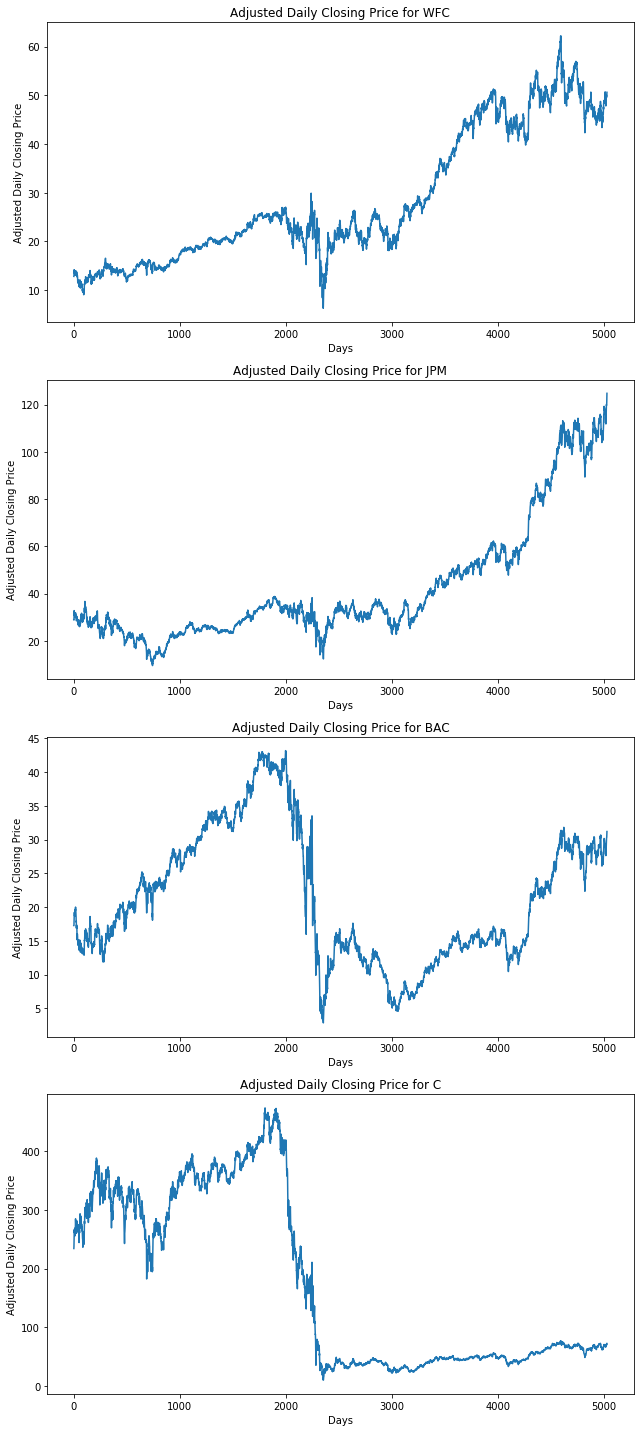

In [302]:
# Plotting Adjusted Daily Closing Price with respect to time.
days = list(range(len(df)))

fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    t = tickers[i]
    adj_close_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['adjusted_close', t])].tolist()
    
    ax[i].plot(days, adj_close_t)
    ax[i].set_title('Adjusted Daily Closing Price for {}'.format(t))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Adjusted Daily Closing Price')
    
plt.show()

It appears that after the company went IPO, the price of the stock climbed for about the first year, then crashed over the period of another year. Afterwards the price continued to fluctuated about an average value for about 5 years, then started slowly climbing again to the current price. There doesn't seem to be anything unusual about this behavior in my opinion.

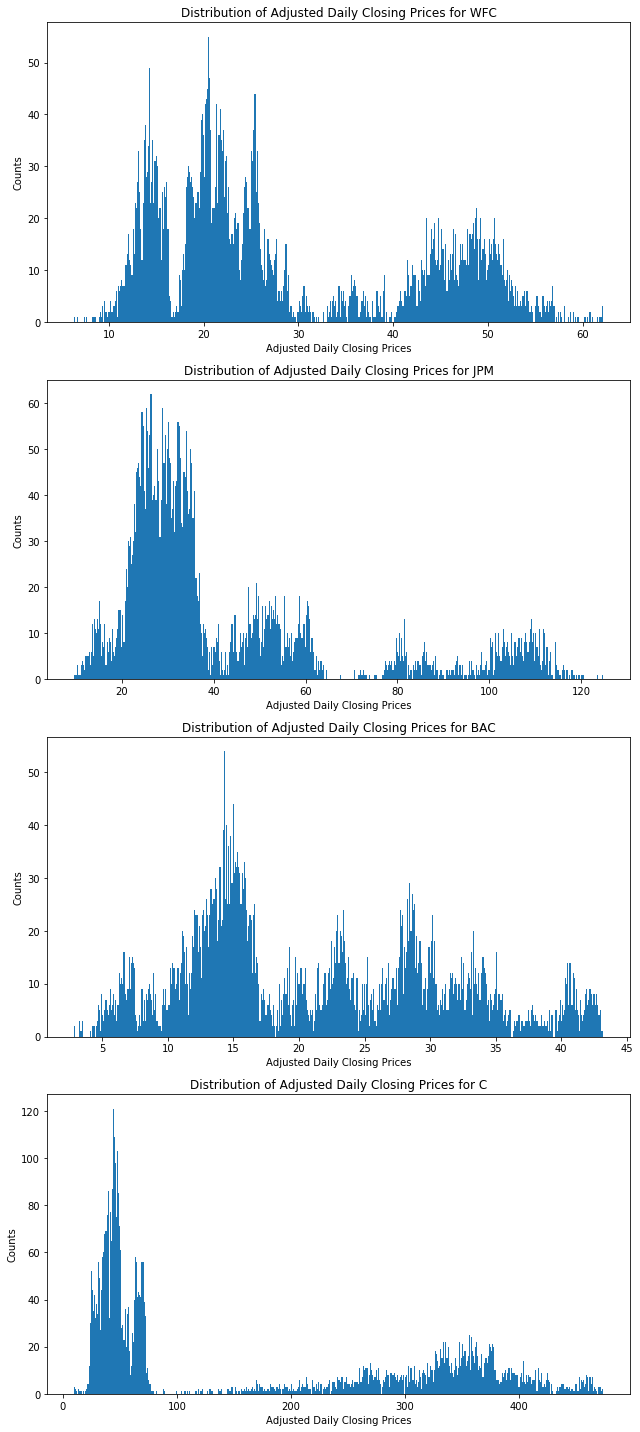

In [304]:
# Plotting the distribution of Adjusted Daily Closing Prices
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    ax[i].hist(df['_'.join(['adjusted_close', tickers[i]])].tolist(), bins=500)
    ax[i].set_title('Distribution of Adjusted Daily Closing Prices for {}'.format(tickers[i]))
    ax[i].set_xlabel('Adjusted Daily Closing Prices')
    ax[i].set_ylabel('Counts')
    
plt.show()

The distribution of Adjusted Daily Closing Prices looks like it could be log-normal which is the distribution type that prices should approximately follow.

In [305]:
# Calculating the log adjusted closing prices, and log adjusted daily returns
for t in tickers:
    df['_'.join(['log_adj_close', t])] = np.log(df['_'.join(['adjusted_close', t])])
    df['_'.join(['log_adj_daily_returns', t])] = df['_'.join(['log_adj_close', t])].shift(1) - df['_'.join(['log_adj_close', t])]
    df = df.dropna(subset=['_'.join(['log_adj_daily_returns', t])])

We are calculating the log of Adjusted Daily Closing Price as well as the difference between the logs of Adjusted Daily Closing Price because if Adjusted Daily Closing Price is log-normal distributed, then the distributions of these values should be normally distributed. This is because the log of a log-normally distributed variable should be normally distributed, and the sum (or difference) of independently normally distributed variables should also be normally distributed. (We are assuming each Adjusted Daily Closing Price is independently distributed from others, which is approximately true.)

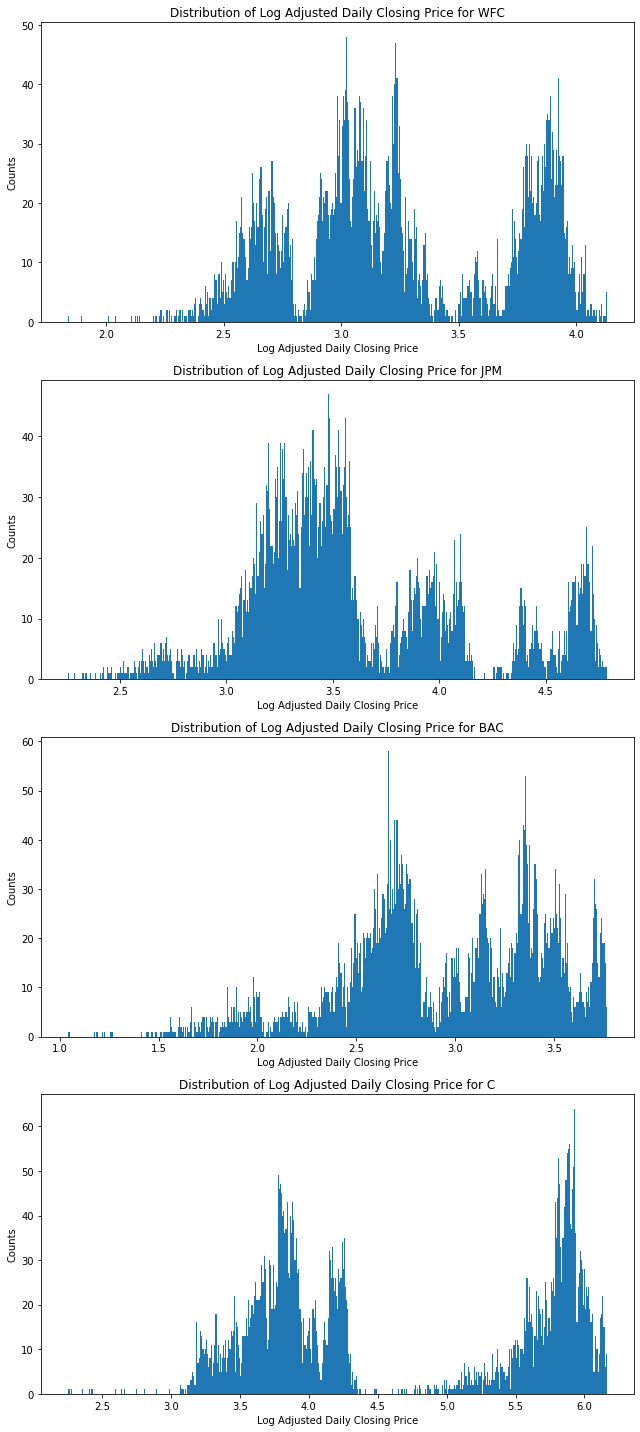

In [306]:
# Plotting the distribution of Log Adjusted Daily Closing Price
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    ax[i].hist(df['_'.join(['log_adj_close', tickers[i]])].tolist(), bins=500)
    ax[i].set_title('Distribution of Log Adjusted Daily Closing Price for {}'.format(tickers[i]))
    ax[i].set_xlabel('Log Adjusted Daily Closing Price')
    ax[i].set_ylabel('Counts')

plt.show()

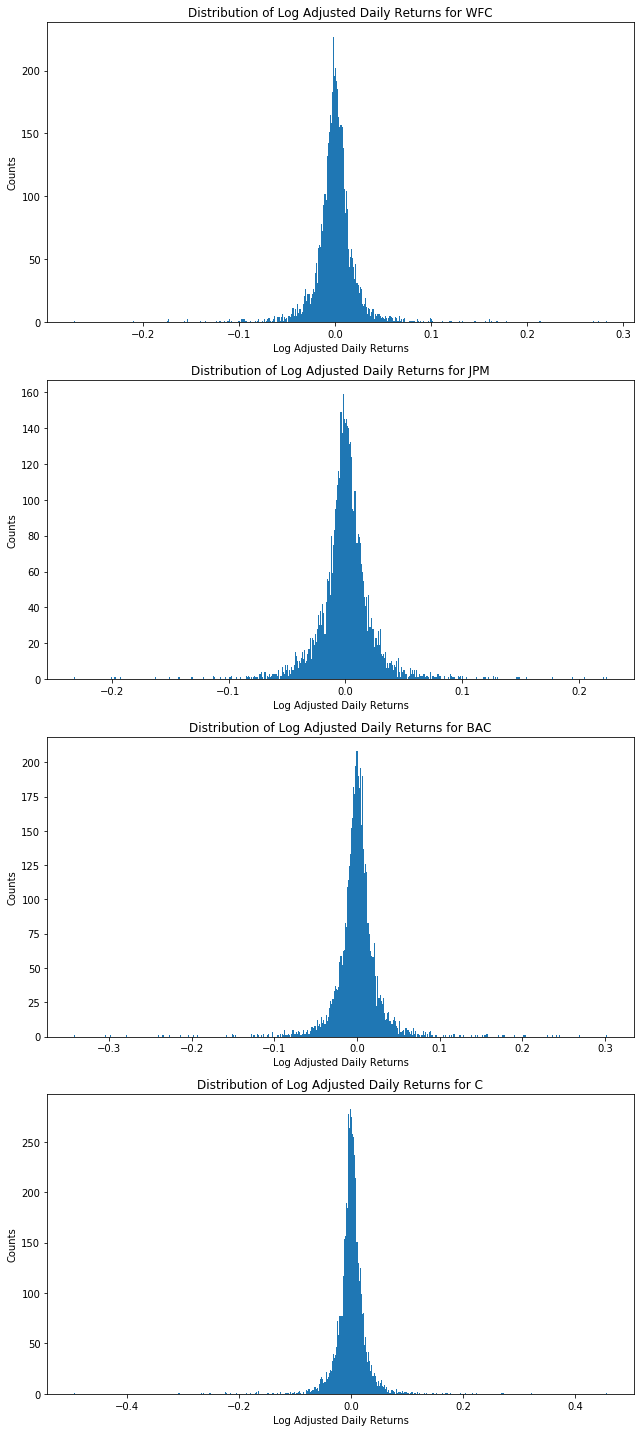

In [307]:
# Plotting the distribution of Log Adjusted Daily Returns
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    ax[i].hist(df['_'.join(['log_adj_daily_returns', tickers[i]])].tolist(), bins=500)
    ax[i].set_title('Distribution of Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax[i].set_xlabel('Log Adjusted Daily Returns')
    ax[i].set_ylabel('Counts')

plt.show()

Although the distribution of log Adjusted Daily Closing Price doesn't appear to be too normal, the distribution of Log Adjusted Daily Returns appears to visually fit a normal distribution well. Therefore we are probably safe in make our assumptions about log-normal prices, and independently distributed prices.

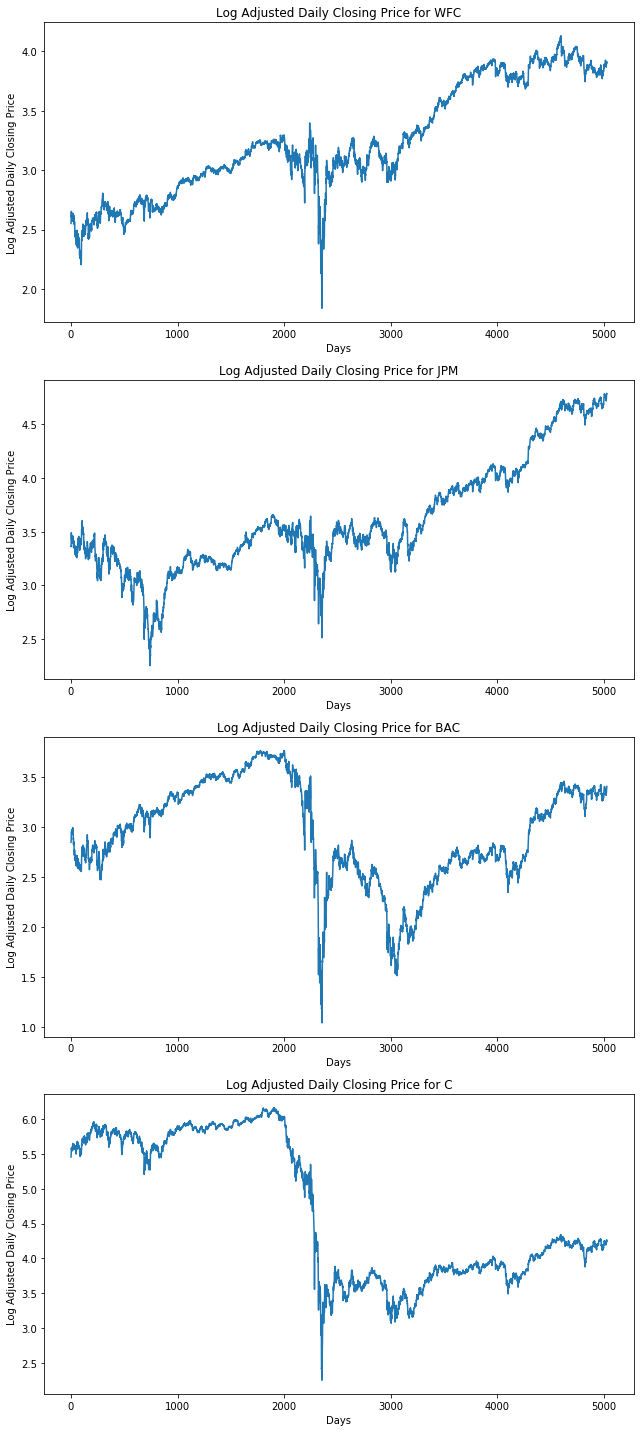

In [308]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    log_adj_close_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_close', tickers[i]])].tolist()
    ax[i].plot(days, log_adj_close_t)
    ax[i].set_title('Log Adjusted Daily Closing Price for {}'.format(tickers[i]))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Log Adjusted Daily Closing Price')
    
plt.show()

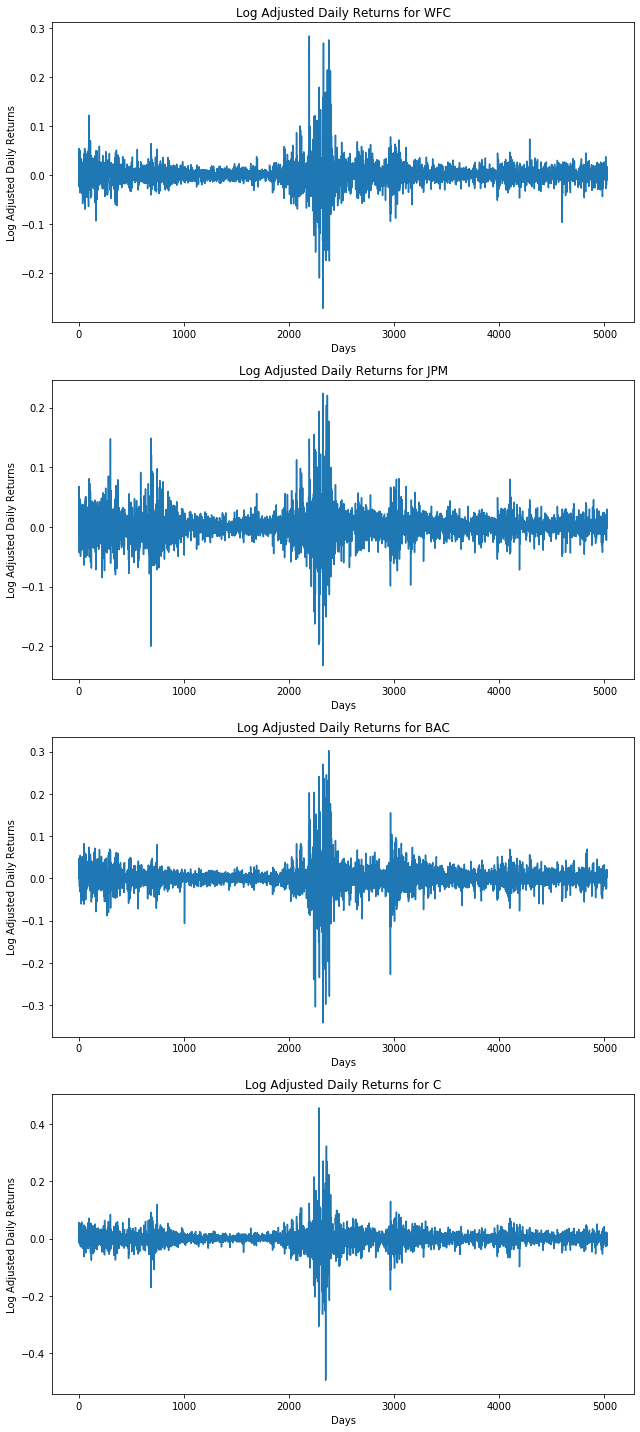

In [309]:
# Plotting Adjusted Daily Returns with respect to time
days = list(range(len(df)))
fig, ax = plt.subplots(len(tickers), 1, figsize=(9, 20), tight_layout=True)

for i in range(len(tickers)):
    log_adj_daily_returns_t = df.sort_values(by='timestamp', ascending=True)['_'.join(['log_adj_daily_returns', tickers[i]])].tolist()
    ax[i].plot(days, log_adj_daily_returns_t)
    ax[i].set_title('Log Adjusted Daily Returns for {}'.format(tickers[i]))
    ax[i].set_xlabel('Days')
    ax[i].set_ylabel('Log Adjusted Daily Returns')
    
plt.show()

The time series of log Adjusted Daily Closing Price appears similar to the time series of Adjusted Daily Closing Price. This is as expected and not unusual because we are just taking a log a variable and thus the overall shape of the graph should not be affected. On the other hand the time series of log Adjusted Daily Returns appears to fluctuate about zero where the magnitude of the fluctuation does not change too much except for at a few pivitol days. This makes sense with respect to its Gaussian distribution, because the Gaussian distribution alots small probabilities to large magnitudes of log Adjusted Daily Return which means there should not be too many days where we see a huge value for log Adjusted Daily Return.

### Text Data

The first thing we will check are the lengths of our raw documents.

In [310]:
# Constructing doc_lengths: a list of lengths of all 8-K forms before they are normalized
doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        doc_lengths_paths_dict[len(raw_doc_text)] = doc_path

In [311]:
print("Largest document has: {} charcters".format(max(doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(doc_lengths_paths_dict.keys())))
largest_doc_path = doc_lengths_paths_dict[max(doc_lengths_paths_dict.keys())]
smallest_doc_path = doc_lengths_paths_dict[min(doc_lengths_paths_dict.keys())]

Largest document has: 125997383 charcters
Smallest document has: 3548 charcters


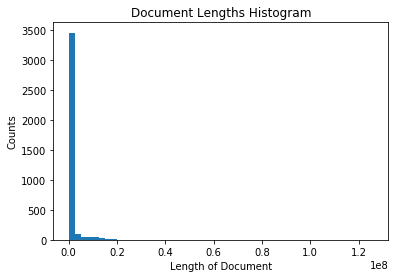

In [312]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50)
ax.set_title('Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

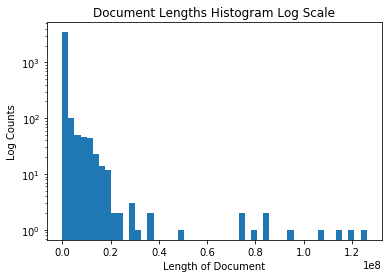

In [313]:
fig, ax = plt.subplots()
ax.hist(doc_lengths_paths_dict.keys(), bins=50, log=True)
ax.set_title('Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

From the above histograms, it appears very few of our documents contain over 30 million characters. Most of our documents seem to have 10 million characters or less with a large emphasize on documents with less than 1 million characters. Since a single characters is about 1 byte in memory, our largest document should be about 125 MB. Therefore we should expect all of our documents to be able to fit into our RAM of 32 GB

#### Text Normalizing

To preprocess our text data, we will first strip it of its x/html tags if the data is encoded this way. Next we will un accent its accented characters, lower case the entire document, and replace all newline/carriage returns with spaces. Next we will strip it of its characters that are not alphanumeric, periods, dollar symbols, or percent symbols. Afterwards we will reduce all words to their dictionary lemmas, and strip the document of its stop words (see stop word list for spacy en_cor_web_sm model). Finally we will replace all whitespace characters with regular space characters, and drop words that are longer in length than a certian cutoff.

The structure of our 8-K filing document involves an xml SEC document header packed with metadata about the filing, and one or multiple xml `<DOCUMENT>` tags. These `<DOCUMENT>` tags contain different types of data that are bundled up into the complete submission for the 8-K filing. The data types stored in these `<DOCUMENT>` tags can range from everything including: regular text data such as html, to binary blob data such as jpg images and pdfs. The structure of these `<DOCUMENT>` tags involve a few meta data tags, none of which involve specifying the encoding type of the data that `<DOCUMENT>` tag stores, and a `<TEXT>` tag that stores the actual data.

Since the inclusion of binary blobs in the markdown prevents easy parsing of the filing structure with lxml, we will result to python re statements to extract the relevant `<DOCUMENT>` tags. Though because the meta data tags enclosed in a `<DOCUMENT>` tag do not specify the encoding type of the data enclosed in the `<TEXT>` tag, there does not appear to be an easy quick general solution that extracts the text data `<DOCUMENT>` tags and avoids the binary blob like `<DOCUMENT>` tags. Because of the above issues we will have to suffice ourselves with extracting only the `<DOCUMENT>` tag that contain's the meta data open tag `<TYPE>8-K`. This specific `<DOCUMENT>` tag always contains text data, and represents the data that is used to generate the SEC 8-K form containing the information that is mandated by the SEC, and excluding the exhibit information that is not mandated by the SEC and is given by the company's discretion. Since this `<DOCUMENT>` tag contains all the mandated information by the SEC for a given 8-K filing, we are still extracting the important information bundled in the filing even though we are not extracting all of the textual information.

In [433]:
# Defining Functions and Classes

def extract_8k(doc):
    eight_k = re.findall('<DOCUMENT>\n<TYPE>8-K.*?<SEQUENCE>1(.*?)</DOCUMENT>', doc, re.DOTALL | re.IGNORECASE)
    text = re.findall('<TEXT>(.*?)</TEXT>', eight_k[0], re.DOTALL | re.IGNORECASE)
    return text

def extract_html(doc):
    html = re.findall('<HTML(?:>| .*?>).*?</HTML>', doc, re.DOTALL | re.IGNORECASE)
    return html

def strip_tags(doc):
    # extracting 8-K <DOCUMENT> tag from the filing
    eight_k = extract_8k(doc)
    assert len(eight_k) == 1, 'Check re for 8-K extraction, either multiple 8-K DOCUMENT tags or bad re'
    
    # extracting <html> tag if any
    html = extract_html(eight_k[0])
    assert 0 <= len(html) <= 1, 'Check re for extracting html tags'
    
    # if html exists
    if len(html) == 1:
        html = html[0]
        soup = BeautifulSoup(html, 'lxml')
        stripped = soup.get_text()
    else:
        soup = BeautifulSoup(eight_k[0], 'lxml')
        stripped = soup.get_text()
    
    return stripped

def strip_accented_chars(doc):
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return doc

def strip_special_chars(doc):
    doc = re.sub('[^$A-Za-z0-9%\s.\']', '', doc)
    return doc

def lemmatize(doc):
    document = nlp(doc)
    doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in document])
    return doc

def strip_stop_words(doc):
    document = nlp(doc)
    doc = ' '.join([word.text for word in document if not word.is_stop])
    return doc

def strip_large_words(doc, cut_off=20):
    return ' '.join([word for word in doc.split() if len(word) <= cut_off])

def normalize_document(doc, tags_strip=True, accent_char_strip=True, lower_case=True,
                       no_newlines=True, special_char_strip=True, space_nums=True,
                       lemmatize_words=True, remove_stop_words=True, strip_extra_spaces=True,
                       remove_large_words=False, debug=False):
    '''
    Preprocesses the document :param doc: and returns the normalized document.
    
    :param doc: string, document to normalize
    :param xml_strip: bool, set to True to strip the xml tags
    :param accent_char_strip: bool, set to True to replace accented characters with their non accented versions
    :param lower_case: bool, set to True to lower case the document.
    :param no_newlines: bool, set to True to remove all newlines characters and replace them with spaces
    :param special_char_strip: bool, set to True to remove all characters that are 
                                     not letters, numbers, $, ., %, or spaces
    :param lemmatize_words: bool, set to True to map each word to its lemma
    :param remove_stop_words: bool, set to True to remove stop words
    :param strip_extra_spaces: bool, set to True to replace multiple spaces with one
    :param remove_large_words: int, set to the integer cutoff where words larger than :param remove_large_words:
                               are removed from the text. Set to False if there is no cutoff
    
    ---> string, normalized document
    '''
    if debug:
        print('raw length of doc: {}'.format(len(doc)))
        
    # stripping tags
    if tags_strip:
        doc = strip_tags(doc)
    if debug:
        print('stripped tag length: {}'.format(len(doc)))
    
    # stripping accented characters
    if accent_char_strip:
        doc = strip_accented_chars(doc)
    if debug:
        print('altered accents length: {}'.format(len(doc)))
        
    # lower casing the document
    if lower_case:
        doc = doc.lower()
    if debug:
        print('lower casing length: {}'.format(len(doc)))
    
    # removing new lines and carriage returns and replacing them with spaces
    if no_newlines:
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    if debug:
        print('removing newlines length: {}'.format(len(doc)))
    
    # removing special characters
    if special_char_strip:
        doc = strip_special_chars(doc)
    if debug:
        print('strip special char length: {}'.format(len(doc)))
    
    # lemmatizing the words
    if lemmatize_words:
        doc = lemmatize(doc)
    if debug:
        print('lemmatized doc length: {}'.format(len(doc)))
    
    # stripping stop words
    if remove_stop_words:
        doc = strip_stop_words(doc)
    if debug:
        print('removed stop word length: {}'.format(len(doc)))
    
    # adding spaces in between numbers and remaining special characters
    if space_nums:
        doc = re.sub(r'([\d$%.])', r' \1 ', doc)
    if debug:
        print('spaced num char length: {}'.format(len(doc)))
        
    # Removing large words
    if remove_large_words:
        doc = strip_large_words(doc, cut_off=remove_large_words)
    if debug:
        print('large words removed char length: {}'.format(len(doc)))
        
    # removing extra whitespace
    if strip_extra_spaces:
        doc = re.sub(' +', ' ', doc)
    if debug:
        print('removed extra space length: {}'.format(len(doc)))
    
    return doc

The first thing we will need to confirm is if the re's we constructed for extracting a documents 8-K component, and the html tag (if they exist) works/still works. For the time being the data we will use from each document will only be the text embedded in the 8-K component of the document.

In [315]:
# Checking the extract_8k function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        num_of_8k = len(extract_8k(raw_doc_text))
        if num_of_8k != 1:
            checksout = False
            print('Filing: {0}, contains: {1} 8-K portions, check re of extract_8k, and document.'.format(doc_path, num_of_8k))

if checksout:
    print('The re in extract_8k seems to checkout.')

The re in extract_8k seems to checkout.


In [316]:
# Checking the extract_html function
checksout = True
for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        eight_k = extract_8k(raw_doc_text)[0]
        num_html_tags = len(extract_html(eight_k))
        if not (0 <= num_html_tags <= 1):
            checksout = False
            print('Filing: {0}, contains: {1} html tags, check re of extract_html, and document.'.format(doc_path, num_html_tags))

if checksout:
    print('The re in extract_html seems to checkout.')

The re in extract_html seems to checkout.


In each 8-K filing there should be only one `<DOCUMENT>...</DOCUMENT>` tag that contains a:`<TYPE>8-K` tag. There should also be ONLY one `<html ...>...</html>` tag if the document tag contains an html tag. The above cells verify if any of these conditions are violated on the current dataset.

The next thing we will investigate are the lengths of our normalized texts with no word length cut offs.

In [317]:
# Constructing norm_doc_lengths: a list of lengths of Intel's 8-K forms after they are normalized
norm_doc_lengths_paths_dict = {}

for t in [ticker] + competitors:
    t_docs_path = os.path.join(path_to_docs, t)
    t_doclist = os.listdir(t_docs_path)
    if 'normalized' in t_doclist:
        t_doclist.remove('normalized')    
    for doc_name in t_doclist:
        doc_path = os.path.join(t_docs_path, doc_name)
        with open(doc_path, 'r') as f:
            raw_doc_text = f.read()
        norm_doc = normalize_document(raw_doc_text)
        norm_doc_lengths_paths_dict[len(norm_doc)] = doc_path

In [318]:
print("Largest document has: {} charcters".format(max(norm_doc_lengths_paths_dict.keys())))
print("Smallest document has: {} charcters".format(min(norm_doc_lengths_paths_dict.keys())))
largest_norm_doc_path = norm_doc_lengths_paths_dict[max(norm_doc_lengths_paths_dict.keys())]
smallest_norm_doc_path = norm_doc_lengths_paths_dict[min(norm_doc_lengths_paths_dict.keys())]

Largest document has: 610674 charcters
Smallest document has: 947 charcters


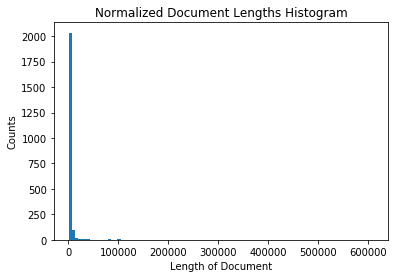

In [319]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100)
ax.set_title('Normalized Document Lengths Histogram')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Counts')
plt.show()

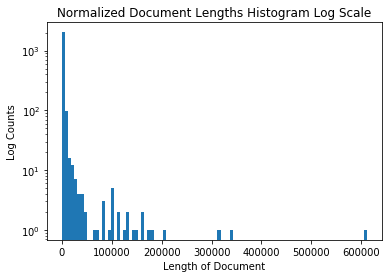

In [320]:
fig, ax = plt.subplots()
ax.hist(norm_doc_lengths_paths_dict.keys(), bins=100, log=True)
ax.set_title('Normalized Document Lengths Histogram Log Scale')
ax.set_xlabel('Length of Document')
ax.set_ylabel('Log Counts')
plt.show()

Nothing seems to stand out in these histograms so far. The next things we will check are the documents that correspond to the extremums of our histograms just to see if anything stands out about these normalized documents.

In [321]:
# Checking Largest Normalized Document
with open(largest_norm_doc_path) as f:
    largest_norm_doc_raw = f.read()

largest_norm_doc = normalize_document(largest_norm_doc_raw, debug=True)
print()
print(largest_norm_doc_path)
print()
print(largest_norm_doc)

raw length of doc: 78927377
stripped tag length: 731646
altered accents length: 728747
lower casing length: 728747
removing newlines length: 728742
strip special char length: 705357
lemmatized doc length: 686438
removed stop word length: 559678
spaced num char length: 708948
large words removed char length: 708948
removed extra space length: 610674

/media/Data/Programs/FinTech/data/documents/JPM/0000019617-11-000266.txt

 exhibit 9 9 2 q 1 1 1 0 q item 1 2 exhibit 9 9 jpmorgan chase co . consolidate financial highlight unaudite million share headcount ratio datum month end june 3 0 as period end 2 q 1 1 1 q 1 1 4 q 1 0 3 q 1 0 2 q 1 0 2 0 1 1 2 0 1 0 selected income statement datum total net revenue $ 2 6 7 7 9 $ 2 5 2 2 1 $ 2 6 0 9 8 $ 2 3 8 2 4 $ 2 5 1 0 1 $ 5 2 0 0 0 $ 5 2 7 7 2 total noninter expense 1 6 8 4 2 1 5 9 9 5 1 6 0 4 3 1 4 3 9 8 1 4 6 3 1 3 2 8 3 7 3 0 7 5 5 preprovision profita 9 9 3 7 9 2 2 6 1 0 0 5 5 9 4 2 6 1 0 4 7 0 1 9 1 6 3 2 2 0 1 7 provision credit loss 1 8 1 

In [322]:
# Checking Smallest Normalized Document
with open(smallest_norm_doc_path, 'r') as f:
    smallest_norm_doc_raw = f.read()

smallest_norm_doc = normalize_document(smallest_norm_doc_raw, debug=True)
print()
print(smallest_norm_doc_path)
print()
print(smallest_norm_doc)

raw length of doc: 4158
stripped tag length: 2312
altered accents length: 2312
lower casing length: 2312
removing newlines length: 2289
strip special char length: 1876
lemmatized doc length: 1897
removed stop word length: 1765
spaced num char length: 1937
large words removed char length: 1937
removed extra space length: 947

/media/Data/Programs/FinTech/data/documents/C/0000950123-02-007241.txt

 u . s . security exchange commission washington d . c . 2 0 5 4 9 form 8 k current report pursuant section 1 3 1 5 d security exchange act 1 9 3 4 date report date early event report july 2 5 2 0 0 2 citigroup inc . exact registrant specify charter delaware 1 9 9 2 4 5 2 1 5 6 8 0 9 9 state commission irs employer jurisdiction file number identification . incorporation 3 9 9 park avenue new york new york 1 0 0 4 3 address principal executive office zip code 2 1 2 5 5 9 1 0 0 0 registrant telephone number include area code citigroup inc . current report form 8 k item 5 . event . july 2 5 2 0 0 

Nothing seems out of the ordinary about these two normalized documents. The relevant information of the 8-K Document sections of the 8-K filings are still there. The Item #.## sections are still existant in these normalized documents, thus they still contain the information that will be important for analysis, albiet with some noise still

#### Normalized Vocabulary Analysis

The second important component of our text data that we must analyze is the vocabulary (the list of unique words) of our normalized document dataset (corpus).  

In [402]:
# Defining Functions and Classes for constructing vocab.json files

def build_vocab(document, file_path):
    '''
    Adds to the already existing vocabulary file found at :param file_path: the new vocabulary found in the 
    normalized document :param document:.

    :param document: string, normalized document to calculate vocabulary from.
    :param file_path: string, path to vocabulary json file
    
    ---> dict, vocab object, mapping words to their unique integer encodings
    '''
    
    # Loading already established vocabulary
    try:
        with open(file_path, 'r') as f:
            vocab = json.load(f)
            
    except FileNotFoundError:
        vocab  = {}
        
    # Updating vocabulary dictionary
    if not vocab:
        last_word_encoding = 0
    else:
        last_word_encoding = max(vocab.values())
    
    for word in document.split():
        # if a word in the document is not in the current vocab, add it with a word encoding value larger than the largest word encoding value
        if word not in vocab:
            vocab[word] = last_word_encoding + 1
            last_word_encoding = last_word_encoding + 1
            
    with open(file_path, 'w') as f:
        json.dump(vocab, f)
    
    return vocab



def vocab_from_doclist(s, path_to_vocab):
    '''
    
    '''
    doclist = json.loads(s)

    for docpath in doclist:
        with open(docpath, 'r') as f:
            doc = f.read()
            norm_doc = normalize_document(doc)
    
        vocab = build_vocab(norm_doc, path_to_vocab)
        
    return json.dumps(doclist)

First we must create our vocab file and load it into a python object.

In [326]:
# Constructing norm_vocab.json file
for t in tickers:
    df['_'.join(['docs', t])].map(lambda s: vocab_from_doclist(s, 'norm_vocab.json'))

In [329]:
# Opening our norm_vocab.json file    
with open('norm_vocab.json', 'r') as f:
    norm_vocab = json.load(f)

Let's view some of the words in our normalized vocabulary.

In [332]:
print(list(norm_vocab.keys()))

['document', 'false', '0', '7', '2', '9', '1', 'well', 'fargo', 'companymndep', 'shr', 'th', 'int', '.', '5', '8', '%', 'fixtofloat', 'noncum', 'perpetual', 'class', 'pref', 'stock', 'ser', 'qdep', '6', 'r', 'wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', '3', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'wfca', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'wfcguaranteeof', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserie

There appears to be alot of nonsense words that seem like they could have come from either column names of tables included in the documents, or badly normalized urls. Removing such words from our documents would thus decrease the noise in our data source. Ideally we would alter our normalization process to split such nonsense words up into real words, but this would be a taxing proces. Alternatively we can prescribe a test of some attribute of a word that is designed to flag most of these nonsense words, and if a word violates our test we remove it from the document.

A lot of these nonsense words also appear to be very long in character length, which implies we might test for nonsense words by testing for word length. Lets analyze the distribution of word length and see if we can choose a cut off for word length that captures most of these nonsense words.

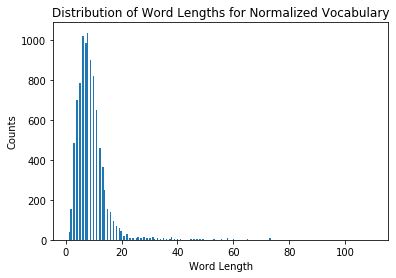

In [334]:
word_lens = list(map(len, norm_vocab.keys()))
fig, ax = plt.subplots()
ax.hist(word_lens, bins=200)
ax.set_title('Distribution of Word Lengths for Normalized Vocabulary')
ax.set_xlabel('Word Length')
ax.set_ylabel('Counts')
plt.show()

It appears that there are very few words with character lengths over 20 characters. This implies that if we choose our cut off to be 20 characters or more, we should not be removing too many words that actually contribute to valuable information when applying our cut off test.

In [338]:
cut_off = 20
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'iiiwbtpnyseguarantee', 'documentsignaturepursuant', 

In [339]:
cut_off = 18
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'iiiwbtpnyseguarantee', 'descriptionlocation', 'docum

In [340]:
cut_off = 16
words_greater_than = [word for word in norm_vocab.keys() if cut_off <= len(word)]
print(words_greater_than)

['wfcnoncumulativeperpetualclassapreferredstockseriesnmember', 'wfcfixedtofloatingrate', 'noncumulativeperpetualclassapfdstockseriesqmember', 'wfcguaranteeofmediumtermnotesseriesadueoctober', 'ofwellsfargofinancellcmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesymember', 'noncumulativeperpetualconvertibleclassapreferredstockserieslmember', 'usgaapcommonstockmember', 'noncumulativeperpetualclassapfdstockseriesrmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesomember', 'wfcnoncumulativeperpetualclassapreferredstockseriestmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesvmember', 'fixedtofloatingratenormalwachoviaincometrustsecuritiesofwachoviacapitaltrustiiimember', 'wfcnoncumulativeperpetualclassapreferredstockserieswmember', 'wfcnoncumulativeperpetualclassapreferredstockseriesxmember', 'wfcnoncumulativeperpetualclassapreferredstockseriespmember', 'commissionwashington', 'employeridentification', 'provisionswritten', 'bprecommencement', 'registeredc

From the above inspection real words like: 'undercapitalized' are captured in the 16 character length cutoff while most real words are not captured in the other cutoffs. This implies that we should use a cutoff of 18 characters or more because it is the largest cutoff that captures the least amount of real words.

### Conclusion

From our exploratory analysis we can conclude that our pricing data seems to fit the assumptions one usually assumes about stock pricing data. This means that the stock pricing data should be distributed log-normally and implies that the log returns of a stock over a period of time should be distributed normally. Our exploratory analysis of our text data shows there is nothing unusual about our raw text data, and it should fit into memory fine. It also shows that our text preprocessing methods still preserve the important parts of our text data and thus should not pose a future issue for analysis. From these findings we can conclude that our raw text data is useable, our text preprocessing methods are useable, and our price data is useable. Since the log returns of our pricing data (Adjusted Daily Closing Price) appear to fit a Gaussian distribution pretty well, our predictor variable in analysis should be log returns (as opposed to Adjusted Daily Closing Price) because the Gaussian distribution has some nice mathematical properties that might be leveraged further on in the future.

## Data Preprocessing

The next phase of our notebook is the Data Preprocessing phase. In this component, we normalize all documents, and preprocess the the data writing our results to a TFRecords file that is then used in the modeling phase.

In [48]:
# Importing Libraries and Loading Variables

import re
import lxml
import json
import pickle
import unicodedata
import en_core_web_sm
import pandas as pd
import tensorflow as tf

from bs4 import BeautifulSoup

df = pd.read_csv(os.path.join(path_to_data, 'raw.csv'), parse_dates=['timestamp'])

Checking if the raw DataFrame was loaded properly.

In [451]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 37 columns):
timestamp                5031 non-null datetime64[ns]
open_WFC                 5031 non-null float64
high_WFC                 5031 non-null float64
low_WFC                  5031 non-null float64
close_WFC                5031 non-null float64
adjusted_close_WFC       5031 non-null float64
volume_WFC               5031 non-null float64
dividend_amount_WFC      5031 non-null float64
split_coefficient_WFC    5031 non-null float64
open_JPM                 5031 non-null float64
high_JPM                 5031 non-null float64
low_JPM                  5031 non-null float64
close_JPM                5031 non-null float64
adjusted_close_JPM       5031 non-null float64
volume_JPM               5031 non-null float64
dividend_amount_JPM      5031 non-null float64
split_coefficient_JPM    5031 non-null float64
open_BAC                 5031 non-null float64
high_BAC                 5031 non-null f

### Preprocessing Data

Redefining functions that will be used in preprocessing for normalizing documents, and building the dataset vocabulary.

In [436]:
# Defining Functions and Classes for Normalizing Documents

def extract_8k(doc):
    eight_k = re.findall('<DOCUMENT>\n<TYPE>8-K.*?<SEQUENCE>1(.*?)</DOCUMENT>', doc, re.DOTALL | re.IGNORECASE)
    text = re.findall('<TEXT>(.*?)</TEXT>', eight_k[0], re.DOTALL | re.IGNORECASE)
    return text

def extract_html(doc):
    html = re.findall('<HTML(?:>| .*?>).*?</HTML>', doc, re.DOTALL | re.IGNORECASE)
    return html

def strip_tags(doc):
    # extracting 8-K <DOCUMENT> tag from the filing
    eight_k = extract_8k(doc)
    assert len(eight_k) == 1, 'Check re for 8-K extraction, either multiple 8-K DOCUMENT tags or bad re'
    
    # extracting <html> tag if any
    html = extract_html(eight_k[0])
    assert 0 <= len(html) <= 1, 'Check re for extracting html tags'
    
    # if html exists
    if len(html) == 1:
        html = html[0]
        soup = BeautifulSoup(html, 'lxml')
        stripped = soup.get_text()
    else:
        soup = BeautifulSoup(eight_k[0], 'lxml')
        stripped = soup.get_text()
    
    return stripped

def strip_accented_chars(doc):
    doc = unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return doc

def strip_special_chars(doc):
    doc = re.sub('[^$A-Za-z0-9%\s.\']', '', doc)
    return doc

def lemmatize(doc):
    document = nlp(doc)
    doc = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in document])
    return doc

def strip_stop_words(doc):
    document = nlp(doc)
    doc = ' '.join([word.text for word in document if not word.is_stop])
    return doc

def strip_large_words(doc, cut_off=20):
    return ' '.join([word for word in doc.split() if len(word) <= cut_off])

def normalize_document(doc, tags_strip=True, accent_char_strip=True, lower_case=True,
                       no_newlines=True, special_char_strip=True, space_nums=True,
                       lemmatize_words=True, remove_stop_words=True, strip_extra_spaces=True,
                       remove_large_words=False, debug=False):
    '''
    Preprocesses the document :param doc: and returns the normalized document.
    
    :param doc: string, document to normalize
    :param xml_strip: bool, set to True to strip the xml tags
    :param accent_char_strip: bool, set to True to replace accented characters with their non accented versions
    :param lower_case: bool, set to True to lower case the document.
    :param no_newlines: bool, set to True to remove all newlines characters and replace them with spaces
    :param special_char_strip: bool, set to True to remove all characters that are 
                                     not letters, numbers, $, ., %, or spaces
    :param lemmatize_words: bool, set to True to map each word to its lemma
    :param remove_stop_words: bool, set to True to remove stop words
    :param strip_extra_spaces: bool, set to True to replace multiple spaces with one
    :param remove_large_words: int, set to the integer cutoff where words larger than :param remove_large_words:
                               are removed from the text. Set to False if there is no cutoff
    
    ---> string, normalized document
    '''
    if debug:
        print('raw length of doc: {}'.format(len(doc)))
        
    # stripping tags
    if tags_strip:
        doc = strip_tags(doc)
    if debug:
        print('stripped tag length: {}'.format(len(doc)))
    
    # stripping accented characters
    if accent_char_strip:
        doc = strip_accented_chars(doc)
    if debug:
        print('altered accents length: {}'.format(len(doc)))
        
    # lower casing the document
    if lower_case:
        doc = doc.lower()
    if debug:
        print('lower casing length: {}'.format(len(doc)))
    
    # removing new lines and carriage returns and replacing them with spaces
    if no_newlines:
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
    if debug:
        print('removing newlines length: {}'.format(len(doc)))
    
    # removing special characters
    if special_char_strip:
        doc = strip_special_chars(doc)
    if debug:
        print('strip special char length: {}'.format(len(doc)))
    
    # lemmatizing the words
    if lemmatize_words:
        doc = lemmatize(doc)
    if debug:
        print('lemmatized doc length: {}'.format(len(doc)))
    
    # stripping stop words
    if remove_stop_words:
        doc = strip_stop_words(doc)
    if debug:
        print('removed stop word length: {}'.format(len(doc)))
    
    # adding spaces in between numbers and remaining special characters
    if space_nums:
        doc = re.sub(r'([\d$%.])', r' \1 ', doc)
    if debug:
        print('spaced num char length: {}'.format(len(doc)))
        
    # Removing large words
    if remove_large_words:
        doc = strip_large_words(doc, cut_off=remove_large_words)
    if debug:
        print('large words removed char length: {}'.format(len(doc)))
        
    # removing extra whitespace
    if strip_extra_spaces:
        doc = re.sub(' +', ' ', doc)
    if debug:
        print('removed extra space length: {}'.format(len(doc)))
    
    return doc

In [437]:
# Defining Functions and Classes for Building vocab.json Files

def build_vocab(document, file_path):
    '''
    Adds to the already existing vocabulary file or creates a vocabulary file found at :param file_path:
    the new vocabulary found in the normalized document :param document:.

    :param document: string, normalized document to calculate vocabulary from.
    :param file_path: string, path to vocabulary json file
    
    ---> :param file_path:
    '''
    
    # Loading already established vocabulary
    try:
        with open(file_path, 'r') as f:
            vocab = json.load(f)
            
    except FileNotFoundError:
        vocab  = {}
        
    # Updating vocabulary dictionary
    if not vocab:
        last_word_encoding = 0
    else:
        last_word_encoding = max(vocab.values())
    
    for word in document.split():
        # if a word in the document is not in the current vocab, add it with a word encoding value larger than the largest word encoding value
        if word not in vocab:
            vocab[word] = last_word_encoding + 1
            last_word_encoding = last_word_encoding + 1
            
    with open(file_path, 'w') as f:
        json.dump(vocab, f)
    
    return vocab

Defining funtions and classes used in preprocessing the raw DataFrame

In [444]:
# Defining Functions and Classes for Preprocessing the DataFrame and Documents

def preprocess(df, cut_off):
    '''
    Preprocesses data, by normalizing all the documents refrenced in df, calculatating the adjusted logarithmic 
    returns for each stock ticker, creating a vocab.json file for the corresponding dataset, and encoding all
    documents refrenced in df according to the created vocab.json file.
    
    :param df: pd.DataFrame, with structure specified in....
    :param cut_off: int, specifies at what character length do we start removing words from a document in
                    the normalization process
    
    ---> pd.DataFrame, preprocessed DataFrame containing refrences to encoded documents and relevant calculations
    '''
    
    # Deep copying input DataFrame making sure that the input isn't modified as a result of this function
    df = df.copy(deep=True)
    
    def normalize_save_document(link, cut_off, endpoint):
        '''
        Normalize, and save normalized document located at link. The normalized document is saved at location endpoint.
        Returns a path to the saved normalized document.
        
        :param link: string, path to document to be normalized
        :param endpoint: string, path to location to save normalized document
        
        ---> string, path to saved normalized document
        '''
        
        doc_name = os.path.split(link)[-1]
        
        if not os.path.isdir(endpoint):
            os.mkdir(endpoint)
            
        with open(link, 'r') as file:
            raw_document = file.read()
            
        norm_doc = normalize_document(raw_document, remove_large_words=cut_off)
        
        with open(os.path.join(endpoint, doc_name), 'w') as normalized_file:
            normalized_file.write(norm_doc)
        
        return os.path.join(endpoint, doc_name)
      
    def norm_doclist(s):
        '''
        Takes a json formated string :param s: which contains a list of raw document paths, normalizes each document
        in the list, and returns an updated json formated string containing the list of normlized document paths.
        
        :param s: string, json formated, when loaded contains a list of paths to raw documents
        
        ---> string, json formatted, updated list of paths to normalized documents
        '''
        doclist = json.loads(s)
        updated_doclist = []
        
        for docpath in doclist:
            save_point = os.path.join(os.path.split(docpath)[0], 'normalized')
            norm_docpath = normalize_save_document(docpath, cut_off=cut_off, endpoint=save_point)
            updated_doclist.append(norm_docpath)
            
        return json.dumps(updated_doclist)
    
    # Normalizing and updating documents  
    for t in tickers:
        df['_'.join(['docs', t])] = df['_'.join(['docs', t])].map(norm_doclist)
        
    # Preprocessing numerical data
    for t in tickers:
        df['_'.join(['log_adj_close', t])] = np.log(df['_'.join(['adjusted_close', t])])
        df['_'.join(['log_adj_daily_returns', t])] = df['_'.join(['log_adj_close', t])] - df['_'.join(['log_adj_close', t])].shift(-1)
        
    df = df.dropna(subset=['_'.join(['log_adj_daily_returns', tickers[0]])])
    
    def vocab_from_doclist(s, path_to_vocab):
        '''
        Takes a json formated string :param s: that contains a list of document paths, and constructs or adds to an
        already existing vocab.json file, the unique words found in the documents refrenced in the list of document
        paths.
        
        :param s: string, json formated, contains a list of paths to documents
        :param path_to_vocab: string, path to vocab.json file
        
        ---> :param s:
        '''
        
        doclist = json.loads(s)
        
        for docpath in doclist:
            with open(docpath, 'r') as f:
                doc = f.read()
            
            vocab = build_vocab(doc, path_to_vocab)
        
        return json.dumps(doclist) 
    
    # Building vocabulary json file
    path_to_vocab = os.path.join(path_to_data, 'vocab.json')
    
    for t in tickers:
        df['_'.join(['docs', t])].map(lambda s: vocab_from_doclist(s, path_to_vocab))
    
    def encode_doclist(s, vocab):
        '''
        Takes a json formated string :param s: which contains a list of document paths, encodes each document
        in the list according to :param vocab: and saves it as a pickle in a file named encoded, and 
        returns an updated json formated string containing the list of encoded document paths.
        
        :param s: string, json formated, when loaded contains a list of paths to documents to encode
        :param vocab: dict, mapping individual words in documents to another python object that encodes an
                      individual word
        
        ---> string, json formated updated list of paths to encoded document files
        '''
        
        def encode_save_document(docpath):
            '''
            Takes a path to a document and encodes it according to outside state vocab, then saves encoded document
            as a pickle in a file named encoded.
            
            :param docpath: string, path to document to encode
            
            ---> string, path to encoded document pickle
            '''
            
            root, doc_name = os.path.split(docpath)
            
            # Defining save point for encoded documents
            save_point = os.path.join(root, 'encoded')
            if not os.path.isdir(save_point):
                os.mkdir(save_point)
            
            with open(docpath, 'r') as tfile:
                text = tfile.read()
                
            # Encoding document
            encoded_document = [vocab[word] for word in text.split()]
            
            # Saving encoded document
            doc_name = '.'.join([os.path.splitext(doc_name)[0], 'pickle'])
            with open(os.path.join(save_point, doc_name), 'wb') as bfile:
                pickle.dump(encoded_document, bfile)
            
            return os.path.join(save_point, doc_name)
        
        return json.dumps(list(map(encode_save_document, json.loads(s))))
    
    # Encoding documents according to vocabulary
    with open(path_to_vocab, 'r') as f:
        vocab = json.load(f)
    
    for t in tickers:
        df['_'.join(['docs', t])] = df['_'.join(['docs', t])].map(lambda s: encode_doclist(s, vocab))         

    return df

Preprocessing the raw DataFrame.

In [439]:
preprocessed_df = preprocess(df, cut_off=18)

Checking if our DataFrame was preprocessed correctly. 

In [440]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5030 entries, 0 to 5029
Data columns (total 45 columns):
timestamp                    5030 non-null datetime64[ns]
open_WFC                     5030 non-null float64
high_WFC                     5030 non-null float64
low_WFC                      5030 non-null float64
close_WFC                    5030 non-null float64
adjusted_close_WFC           5030 non-null float64
volume_WFC                   5030 non-null float64
dividend_amount_WFC          5030 non-null float64
split_coefficient_WFC        5030 non-null float64
open_JPM                     5030 non-null float64
high_JPM                     5030 non-null float64
low_JPM                      5030 non-null float64
close_JPM                    5030 non-null float64
adjusted_close_JPM           5030 non-null float64
volume_JPM                   5030 non-null float64
dividend_amount_JPM          5030 non-null float64
split_coefficient_JPM        5030 non-null float64
open_BAC           

In [441]:
preprocessed_df.head()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
0,2019-10-22,50.44,51.02,50.23,50.62,50.62,18007709.0,0.0,1.0,123.45,...,[],[],3.924347,0.003166,4.826632,0.009986,3.440418,0.005786,4.277499,0.003475
1,2019-10-21,50.28,50.50,50.18,50.46,50.46,19409100.0,0.0,1.0,122.05,...,[],[],3.921181,0.009758,4.816646,0.024498,3.434632,0.021836,4.274024,0.029250
2,2019-10-18,49.34,50.22,49.32,49.97,49.97,21199500.0,0.0,1.0,120.00,...,[],[],3.911423,0.007230,4.792148,0.001743,3.412797,0.002970,4.244774,0.002009
3,2019-10-17,49.98,50.17,49.48,49.61,49.61,20560100.0,0.0,1.0,120.75,...,[],[],3.904192,0.000403,4.790404,0.005583,3.409827,0.002979,4.242765,0.001438
4,2019-10-16,50.04,50.28,49.45,49.59,49.59,23728400.0,0.0,1.0,119.96,...,"[""/media/Data/Programs/FinTech/data/documents/...",[],3.903789,-0.010431,4.784822,-0.002337,3.406848,0.014691,4.241327,-0.024447


In [442]:
preprocessed_df.tail()

,timestamp,open_WFC,high_WFC,low_WFC,close_WFC,adjusted_close_WFC,volume_WFC,dividend_amount_WFC,split_coefficient_WFC,open_JPM,...,docs_BAC,docs_C,log_adj_close_WFC,log_adj_daily_returns_WFC,log_adj_close_JPM,log_adj_daily_returns_JPM,log_adj_close_BAC,log_adj_daily_returns_BAC,log_adj_close_C,log_adj_daily_returns_C
5025,1999-11-01,23.500,23.594,23.156,23.438,13.5640,10083800.0,0.0,1.0,86.625,...,[],[],2.607419,-0.021111,3.432670,-0.043183,2.956113,0.006765,5.568721,-0.016260
5026,1999-10-29,24.250,24.531,23.625,23.938,13.8534,11853400.0,0.0,1.0,88.125,...,[],[],2.628531,-0.024500,3.475853,-0.014929,2.949348,0.006816,5.584981,0.002306
5027,1999-10-28,24.063,24.969,23.875,24.531,14.1970,24287800.0,0.0,1.0,85.500,...,[],[],2.653031,0.053643,3.490782,0.067882,2.942532,0.046985,5.582674,0.056094
5028,1999-10-27,22.563,23.250,22.438,23.250,13.4555,11327200.0,0.0,1.0,78.063,...,[],[],2.599388,0.039760,3.422900,0.061522,2.895547,0.046078,5.526580,0.056370
5029,1999-10-26,22.375,22.719,22.219,22.344,12.9310,11607400.0,0.0,1.0,78.313,...,[],"[""/media/Data/Programs/FinTech/data/documents/...",2.559628,0.008426,3.361378,-0.001605,2.849469,0.001077,5.470209,0.014276


It looks like our preprocessed DataFrame checks out. Next, we will save our preprocessed DataFrame to disk 

In [443]:
# Saving preprocessed DataFrame to Disk
preprocessed_df.to_csv(os.path.join(path_to_data, 'preprocessed.csv'), index=False)

### Writing Dataset to TFRecords

After sucessfully preprocessing our dataset we next write our dataset to a TFRecords file (https://www.tensorflow.org/tutorials/load_data/tfrecord) a binary file format that is read efficiently by the TensorFlow framework. 

In [3]:
# Defining Functions and Classes used to write TFRecord files

def serialize_example(sample, feature_names):
    '''
    Maps dictionary :param sample: to a tf.train.Example object where the list feature_names determines which 
    subset of :param sample:'s keys are to be used. 
    
    :param sample: dict, where the keys are the names of the features of the specific data sample, and the values 
                   are the values each feature takes on for the specific data sample
    :param feature_names: list, of strings, a subset of sample.keys(), these are the features we will
                          be considering for analysis
    
    ---> tf.train.Example, object representing the data sample
    '''
    
    feature = {}
    feature_description = {}
    
    for feature_name in feature_names:
        # if feature is a float number 
        if isinstance(sample[feature_name], float):
            feature[feature_name] = tf.train.Feature(float_list=tf.train.FloatList(value=[sample[feature_name]]))
            feature_description[feature_name] = tf.io.FixedLenFeature([], tf.float32)
        
        # if feature is a list of documents
        elif isinstance(sample[feature_name], list) and all(isinstance(word, int) for doc in sample[feature_name] for word in doc):
            lens = list(map(len, sample[feature_name]))
            values = [word for doc in sample[feature_name] for word in doc]
            feature[feature_name + '/vals'] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))
            feature[feature_name + '/lens'] = tf.train.Feature(int64_list=tf.train.Int64List(value=lens))
            feature_description[feature_name + '/vals'] = tf.io.VarLenFeature(dtype=tf.int64)
            feature_description[feature_name + '/lens'] = tf.io.VarLenFeature(dtype=tf.int64)
        
        # if feature is an integer number
        elif isinstance(sample[feature_name], int):
            feature[feature_name] = tf.train.Feature(int64_list=tf.train.Int64List(value=[sample[feature_name]]))
            feature_description[feature_name] = tf.io.FixedLenFeature([], tf.int64)
        
        # Feature doesn't fit any of the tf example types
        else:
            raise ValueError('Value of Feature does not fit any of the tf.train.Feature serializable types')

    return tf.train.Example(features=tf.train.Features(feature=feature)), feature_description


def write_tfrecord(df, feature_names, filename='dataset.tfrecord'):
    '''
    Writes TFRecord file named :param filename: to dataset directory, and generates the corresponding 
    feature_description dictionary mapping a sample's feature name to the data type description of that
    feature.
    
    :param df: pd.DataFrame, containing data and refrences to data that needs to be written to disk
    :param feature_names, list of strings, a subset of the names of columns of df, that represents which subset
                          of features from our preprocessed DataFrame that will be considered for modeling
    :param filename: string, name of TFRecord file
    
    ---> dict, of names of features mapping to tf.io.VarLenFeature and tf.io.FixedLenFeature objects
    '''
    
    def unpack_doclist(doclist_string):
        '''
        Takes a json format string that when loaded contains a list of paths to encoded document pickle files, and
        returns a list of the objects loaded from these pickle files.
        
        :param doclist_string: string, json formated, contain a list of paths to encoded document pickle files
        
        ---> list, of encoded documents
        '''
        
        def load_file(filename):
            '''
            Takes a path to a pickle file, and returns the loaded object.
            
            :param filename: string, path to pickle file
            
            ---> python object loaded file located at :param filename:
            '''
            
            with open(filename, 'rb') as f:
                doc = pickle.load(f)
            return doc
        
        return list(map(load_file, json.loads(doclist_string)))
    
    with tf.io.TFRecordWriter(os.path.join(path_to_data, filename)) as writer:
        print('Writing TFRecord file to: {}'.format(os.path.join(path_to_data, filename)))
        for i in range(len(df)-1, -1, -1):
            row = df.iloc[i].copy(deep=True)
            # Unpacking Text Features
            row[['_'.join(['docs', t]) for t in tickers]] = row[['_'.join(['docs', t]) for t in tickers]].map(unpack_doclist)
            # Serializing Example to disk
            example, feature_description = serialize_example(row, feature_names)
            writer.write(example.SerializeToString())
    print('Finished writing TFRecord file.')

    return feature_description

In [4]:
# Writing TFRecord file

# Defining the subset of features from our preprocessed DataFrame that we will be using for modeling
feature_names = ['_'.join([feature, t]) for feature in ['log_adj_daily_returns', 'docs'] for t in tickers]
print('The features we will be considering for analysis are: {}'.format(', '.join(feature_names)))
print()
# Loading the preprocessed DataFrame from disk if it has not been instantiated
try:
    preprocessed_df
except:
    preprocessed_df = pd.read_csv(os.path.join(path_to_data, 'preprocessed.csv'), parse_dates=['timestamp'])
# Writing the TFRecord file
feature_description = write_tfrecord(preprocessed_df, feature_names)
# Writing the TFRecord's feature_description object to disk
with open(os.path.join(path_to_data, 'dataset_feature_description.pickle'), 'wb') as f:
    pickle.dump(feature_description, f)

The features we will be considering for analysis are: log_adj_daily_returns_WFC, log_adj_daily_returns_JPM, log_adj_daily_returns_BAC, log_adj_daily_returns_C, docs_WFC, docs_JPM, docs_BAC, docs_C

Writing TFRecord file to: /media/Data/Programs/FinTech/data/dataset.tfrecord
Finished writing TFRecord file.


For this notebook we will be using only the bare minimum amount of features for modeling ie: our text features listed in the doc columns and the feature we are trying to predict in time series.

## Modeling

The goal of this notebook is to discover whether we can construct a deep learning model that correlates (predicts) stock price data with unstructured text data found in company 8-K forms. Specifically for our first models we will try to correlate the logarithmic returns of a stock with the previous logarithmic returns of the stock in a given window of time, along with the text data stored in the companies 8-K forms that were released in the given window of time. If there are multiple 8-K documents released in the given window of time then our text data fed to the model will be derived from a single 8-K document uniformly sampled from the 8-K documents released in the given window of time. This window size (in days) along with architecture of the model will be the hyperparameters that can be tuned when experiment with different model designs. Modeling will consist of two phases: Preparing Data, and Evaluating Models.

In [249]:
# Importing Libraries and Configuring virtual GPU

import os
import json
import pickle
import pandas as pd
import tensorflow as tf

from fractions import Fraction
from functools import reduce
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))

if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Random Seed
tf.random.set_seed(20)
 
# Model Hyperparameters    
## Model Hyperparameters that require reshaping Dataset
TIMESTEPS = 8
BATCH_SIZE = 10
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
## Model 1 Hyperparameters
DOC_EMBEDDING_UNITS = 1000
#TS_LAYER_1_UNITS = 700
TS_LAYER_2_UNITS = 50
TS_LAYER_3_UNITS = 50
OPTIMIZER = keras.optimizers.Adam
LOSS = keras.losses.BinaryCrossentropy()
METRICS = ['accuracy']
LEARNING_RATE=None

GPUs: []
Visible GPUs: []


### Preparing Data

Preparing our data involves:
1. Loading the dataset from the TFRecord file
2. Splitting the dataset by stock ticker
3. Reshaping each dataset to prepare it for training:
    1. Windowing the dataset so each element produces a time series of features along with there corresponding label
    2. Sampling the document feature for the document that will represent the specific window's document and cloning that document for each timestep in our defined window size
    3. Filtering our dataset to include only elements with a document feature
4. Concatenating the reshaped datasets together, and shuffling the dataset
5. Splitting the dataset into train, validation, and test datasets

1. Loading the dataset from TFRecord file

In [250]:
# Defining functions and classes used to load the dataset from its TFRecord file

def parse_example(example_proto, feature_description):
    '''
    Parses example proto from
    
    :param example_proto: 
    :param feature_description: 
    '''
    
    # Parse the input tf.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Reconstructing Ragged Tensors from Example
    for t in tickers:
        example['_'.join(['docs', t])] = tf.RaggedTensor.from_row_lengths(example['docs_{}/vals'.format(t)].values,
                                                           row_lengths=example['docs_{}/lens'.format(t)].values)

    # Deleting Redundant Keys
    for t in tickers:
        del example['docs_{}/vals'.format(t)]
        del example['docs_{}/lens'.format(t)]
        
    return example

In [251]:
# Loading the Dataset

# Loading the raw dataset from the TFRecord file
dataset = tf.data.TFRecordDataset(os.path.join(path_to_data, 'dataset.tfrecord'))
# Loading the dataset's feature_description
with open(os.path.join(path_to_data, 'dataset_feature_description.pickle'), 'rb') as f:
    feature_description = pickle.load(f)
# Decoding the raw dataset using the dataset's feature_description
dataset = dataset.map(lambda example_proto: parse_example(example_proto, feature_description))

2. Spliting the dataset by stock ticker

In [252]:
def split(example, features, ticker):
    return {feature_name: example['_'.join([feature_name, ticker])] for feature_name in features}

datasets = [dataset.map(lambda ex: split(ex, ['log_adj_daily_returns', 'docs'], t)) for t in tickers]

3. Reshaping datasets

In [253]:
# Defining functions and classes used to reshape datasets

def make_window_dataset(ds, window_size, shift=1, stride=1):
    
    windows = ds.window(window_size, shift=shift, stride=stride)
    
    feature_datasets = {key: windows.flat_map(lambda x: x[key].batch(window_size, drop_remainder=True))
                        for key in windows.element_spec.keys()}
    
    return tf.data.Dataset.zip(feature_datasets)

def extract_labels(timeslice, label_features):
    labels = {}
    
    for feature_key in timeslice.keys():
        feature_timeslice = timeslice[feature_key]
        if feature_key in label_features:
            labels[feature_key] = feature_timeslice[-1]
        timeslice[feature_key] = feature_timeslice[:-1]
        
    return (timeslice, labels)


def to_time_series(ds, label_features, window_size, steps_to_pred=1, num_of_preds=1):
    
    # making full time series Dataset object (features + labels)
    full_ts_ds = make_window_dataset(ds, window_size=window_size+1)
    
    # mapping dataset to Dataset where each el is: (features: dict, labels)
    ts_ds = full_ts_ds.map(lambda s: extract_labels(s, label_features))
    
    return ts_ds

def sample_documents(sample):
    # Extracting all documents in the sample
    docs_in_sample = sample.values
    # Sampling a random document from all the documents in the sample
    if docs_in_sample.nrows() != 0:
        i = tf.random.uniform([1], maxval=docs_in_sample.nrows(), dtype=tf.int64)[0]
        sample_doc = docs_in_sample[i]
    else:
        sample_doc = tf.constant([], dtype=tf.int64)
        
    return sample_doc

def select_doc(features, labels):
    
    for fname in features.keys():
        feature = features[fname]
        timesteps = feature.shape[0]
        # Feature is a doc feature
        if isinstance(feature, tf.RaggedTensor):
            doc = sample_documents(feature)
            feature = tf.stack([doc for day in range(timesteps)])
            features[fname] = feature
        
    return (features, *list(labels.values()))

def filter_fn(f, l):
    shape = tf.shape(f['docs'])[1]
    return tf.math.not_equal(shape, 0)

def reshape(dataset, window_size, label_name):
    # Converting to time series
    ds = to_time_series(dataset, label_name, window_size=window_size)
    # Selecting document features
    ds = ds.map(select_doc)
    # Filtering out elements without a document feature
    ds = ds.filter(filter_fn)
    return ds

In [254]:
# Reshaping Datasets
reshaped_datasets = list(map(lambda d: reshape(d, TIMESTEPS, 'log_adj_daily_returns'), datasets))

4. Concatenating datasets, and shuffling dataset

In [255]:
dataset = reduce(lambda a, b: a.concatenate(b), reshaped_datasets).shuffle(1000, reshuffle_each_iteration=False)

5. Splitting dataset into train, validation, and test datasets

In [256]:
# Defining Functions and Classes for splitting datasets into train, validation, and test datasets

def k_folds(dataset, k):
    '''
    Splits :param dataset: into :param k: number of equally sized (or close to equally sized) components.
    
    :param dataset: tf.data.Dataset, dataset to split into k folds
    :param k: int, number of folds to split :param dataset: into
    
    ---> list, of tf.data.Dataset objets
    '''
    return [dataset.shard(k, i) for i in range(k)]

def train_test_split(dataset, train_size):
    '''
    Splits :param dataset: into
    
    :param dataset: tf.data.Dataset, to split into train and test datasets
    :param train_size: float between 0 and 1, proportion of :param dataset: to put into train dataset
    
    ---> (tf.data.Dataset, tf.data.Dataset), representing train, test datasets
    '''
    train_size = Fraction(train_size).limit_denominator()
    x, k = train_size.numerator, train_size.denominator
    folds = k_folds(dataset, k)
    train = reduce(lambda a, b: a.concatenate(b), folds[:x])
    test = reduce(lambda a, b: a.concatenate(b), folds[x:])
    return train, test

For our models we will reserve 60% of the dataset for training, 20% for validation, and 20% for testing.

In [257]:
# Splitting our dataset into train, validation, test datasets

# Creating datasets
train_dataset, test_val_dataset = train_test_split(dataset, train_size=0.6)
val_dataset, test_dataset = train_test_split(test_val_dataset, train_size=0.5)

# Prepping datasets for modeling
train_dataset = (train_dataset.shuffle(10)
                 .padded_batch(batch_size, 
                               padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                               'docs': [TIMESTEPS, None]}, [])))
val_dataset = (val_dataset.shuffle(10)
               .padded_batch(batch_size, 
                             padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                             'docs': [TIMESTEPS, None]}, [])))
test_dataset = (test_dataset.shuffle(10)
                .padded_batch(batch_size, 
                              padded_shapes=({'log_adj_daily_returns': [TIMESTEPS,], 
                                              'docs': [TIMESTEPS, None]}, [])))



### Evaluating Models

In [258]:
# Defining functions and classes used to construct model layers

def embedding_matrix(vocab, init):
    '''
    Constructs the embedding matrix for specific init type for a pre initialized word embedding layer.
    
    :param vocab: dict, a mapping between keys of words, and values of unique integer identifiers for each word
    :param init: string, initialization type currently we only support glove initialization
    
    ---> numpy array of size (vocab length, embedding dimension) mapping each word encoding to a vector
    '''
    
    if init == 'glove':
        glove_dir = 'glove'
        
        try:
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'rb') as f:
                embedding_m = pickle.load(f)
            
        except FileNotFoundError:
            # Building word to vector map
            word_embeddings = {}
            with open(os.path.join(glove_dir, 'glove.840B.300d.txt')) as f:
                for line in f:
                    tokens = line.split(' ')
                    word = tokens[0]
                    embedding = np.asarray(tokens[1:], dtype='float32')
                    # Needs to check if dim is changing
                    assert len(embedding) == 300
                    word_embeddings[word] = embedding
            # Building embedding matrix
            EMBEDDING_DIM = len(next(iter(word_embeddings.values())))
            embedding_m = np.zeros((len(vocab) + 1, EMBEDDING_DIM))
            for word, i in vocab.items():
                embedding_vector = word_embeddings.get(word)
                if embedding_vector is not None:
                    embedding_m[i] = embedding_vector
            # Saving embedding matrix
            with open(os.path.join(glove_dir, 'current_embedding.pickle'), 'wb') as f:
                pickle.dump(embedding_m, f)
                
    else:
        raise ValueError('init type not supported, init must be equal to "glove"')

    return embedding_m

def Word_Embedding(vocab, init, 
                   embeddings_initializer='uniform', embeddings_regularizer=None, 
                   activity_regularizer=None, embeddings_constraint=None, 
                   mask_zero=False, input_length=None, **kwargs):
    
    '''
    Creates a keras embedding layer specifically designed to embed the words specified in :param vocab:
    
    :param vocab: dict, representing the mapping between the words in corpus (keys) and their unique integer
                  encodings
    :param init: string or int, tells the layer how to initialize its embeddings. If of type int, then
                 it tells the layer to initialize its word embeddings with an embedding dimension of :param init:.
                 If of type string, then :param init: specifies the type of pretrained word embeddings we will be 
                 initializing the embedding layer with
    
    ---> tf.keras.layers.Embedding
    '''
    
    if isinstance(init, str):
        current_embedding_matrix = embedding_matrix(vocab, init)
        emb_layer = layers.Embedding(current_embedding_matrix.shape[0], current_embedding_matrix.shape[1],
                                     weights=[current_embedding_matrix], mask_zero=mask_zero,
                                     input_length=None, **kwargs)
        
    elif isinstance(init, int):
        emb_layer = layers.Embedding(len(vocab) + 1, output_dim=init, 
                                     embeddings_initializer=embeddings_initializer, embeddings_regularizer=embeddings_regularizer, 
                                     activity_regularizer=activity_regularizer, embeddings_constraint=embeddings_constraint, 
                                     mask_zero=mask_zero, input_length=input_length, **kwargs)
    else:
        raise ValueError('init type not supported')
        
    return emb_layer


In [259]:
# Defining functions and classes used to construct models

def model_1(timesteps, vocab, doc_embedding_size, ts_layer_1_size, ts_layer_2_size, ts_layer_3_size,
            optimizer, learning_rate, loss, metrics):
    '''
    Constructs a model with the architecture of 
    '''
    
    # Building Input Layers
    input_docs = keras.Input(shape=(timesteps, None), name='docs', dtype=tf.int64)
    input_log_returns = keras.Input(shape=(timesteps,), name='log_adj_daily_returns', dtype=tf.float32)
    # Slicing Document Input Layer along time axis
    timeslice_layer = [input_docs[:, timestep, :] for timestep in range(timesteps)]
    # Building Word Embedding Layer
    word_embedding = Word_Embedding(vocab, init='glove', mask_zero=True, trainable=False)
    word_embedding_layer = [word_embedding(timeslice) for timeslice in timeslice_layer]
    # Building Document Embedding Layer
    document_embedding = layers.LSTM(doc_embedding_size)
    document_embedding_layer = [document_embedding(timeslice) for timeslice in word_embedding_layer]
    # Preparing Features for Time Series Analysis
    num_features = tf.expand_dims(input_log_returns, -1)
    doc_features = tf.stack(document_embedding_layer, axis=1)
    ts_input = num_features #layers.Concatenate()([doc_features, num_features])
    # Building Time Series Layer
    #ts_layer_1 = layers.LSTM(ts_layer_1_size, return_sequences=True)(ts_input)
    ts_layer_2 = layers.LSTM(ts_layer_2_size, activation='relu', return_sequences=True)(ts_input)
    ts_layer_3 = layers.LSTM(ts_layer_3_size, activation='relu')(ts_layer_2)
    # Building Output Layer
    output = layers.Dense(1, activation='sigmoid')(ts_layer_3)
    # Building Model
    model = keras.Model([input_docs, input_log_returns], output, name='model_1')
    # Compiling Model
    if learning_rate == None:
        opt = optimizer()
    else:
        opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model


In [260]:
# Training Model 1 with the current hyperparameters
tf.keras.backend.clear_session()
model = model_1(timesteps=TIMESTEPS, vocab=vocab, doc_embedding_size=DOC_EMBEDDING_UNITS,
                ts_layer_1_size=TS_LAYER_1_UNITS, ts_layer_2_size=TS_LAYER_2_UNITS, ts_layer_3_size=TS_LAYER_3_UNITS,
                optimizer=OPTIMIZER, learning_rate=LEARNING_RATE, loss=LOSS, metrics=METRICS)

print(model.summary())
# Converting data to catagorical data
def to_categorical(f, l):
    if l > 0:
        c = 1
    else:
        c = 0
    return (f, c)

train_dataset = train_dataset.unbatch().map(to_categorical).batch(10)
model.fit(train_dataset, epochs=30, validation_data=train_dataset)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_adj_daily_returns (InputLay [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF [(None, 8, 1)]       0           log_adj_daily_returns[0][0]      
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 8, 50)        10400       tf_op_layer_ExpandDims[0][0]     
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 50)           20200       lstm_1[0][0]                     
____________________________________________________________________________________________

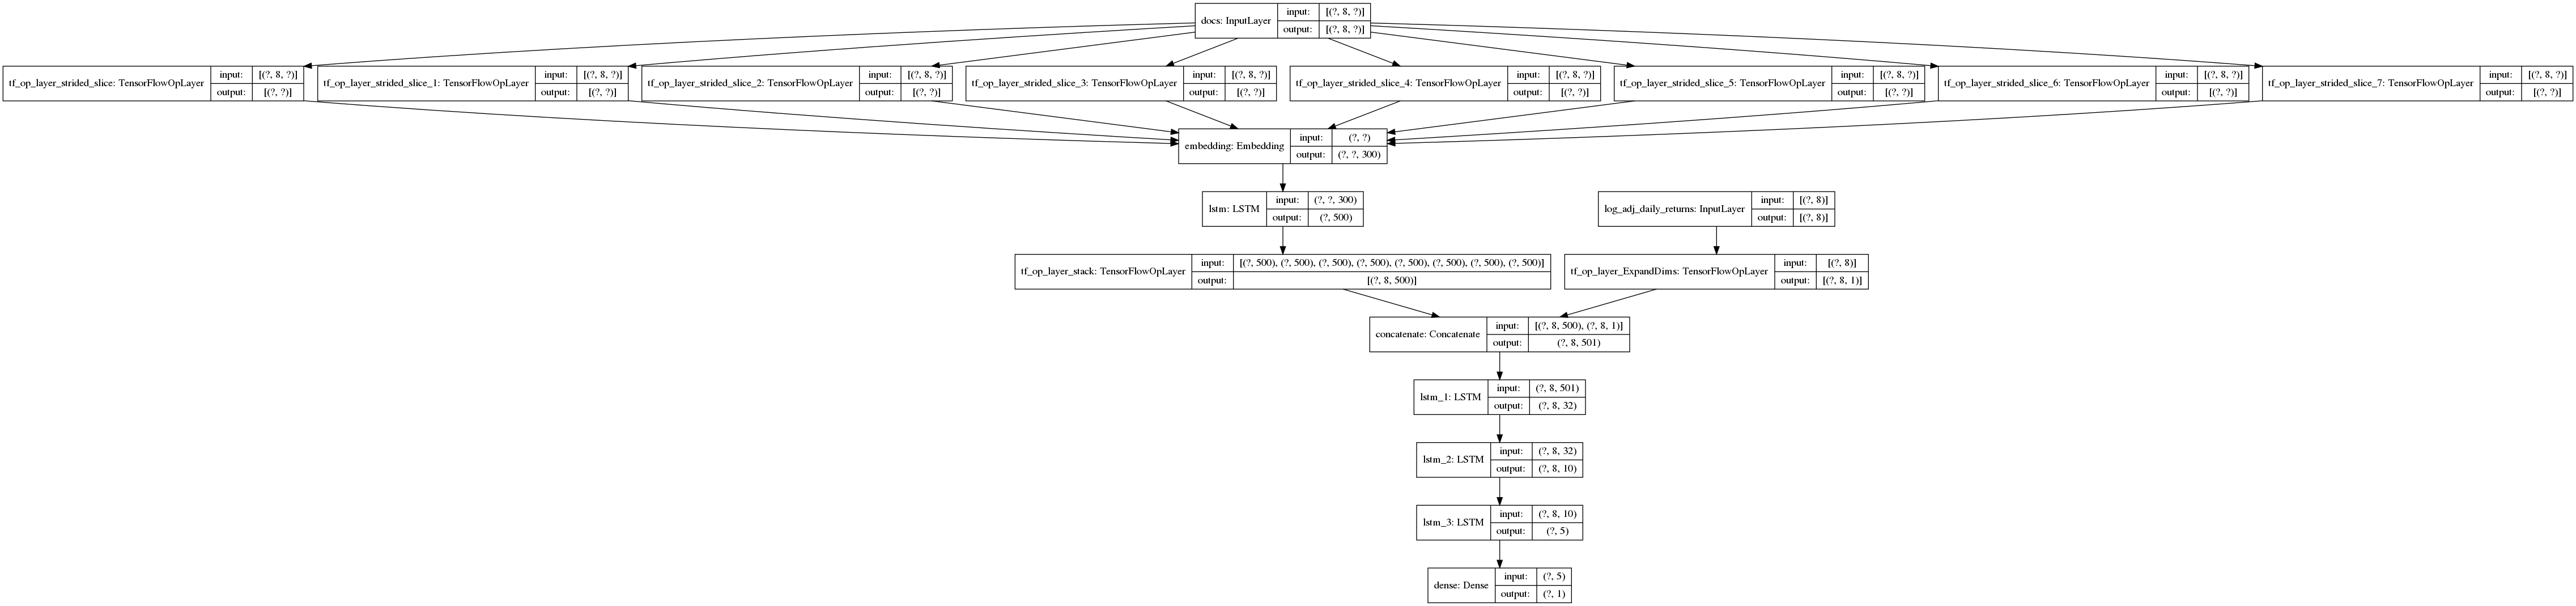

In [134]:
tf.keras.backend.clear_session()
optimizer = keras.optimizers.Adam()
loss = keras.losses.MeanSquaredError()
metrics = [keras.metrics.Accuracy()]
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)
hparams = {'timesteps': window_size, 'vocab': vocab, 'doc_embedding_size': 500, 'ts_layer_1_size': 32,
           'ts_layer_2_size': 10, 'ts_layer_3_size': 5}

model = get_compiled_model(optimizer=optimizer, loss=loss, metrics=metrics, model=model_1, **hparams)
keras.utils.plot_model(model, 'test.png', show_shapes=True)

In [111]:


feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']

# destroying already made graph nodes in the tensorflow backend





timesteps = 5




# document embedding Model

    
with open(os.path.join(path_to_data, 'vocab.json')) as f:
    vocab = json.load(f)
        
#document = keras.Input(shape=(None,), name='document')
#word_embedding = Word_Embedding(vocab, trainable=False)(document)
#document_embedding = layers.LSTM(400)(word_embedding)
#document_embedder = keras.Model(document, document_embedding, name='document_embedder')
#print(document_embedder.summary())

#keras.utils.plot_model(document_embedder, 'document_embedder.png', show_shapes=True)



# Inputs
input_docs_WFC = keras.Input(shape=(timesteps, None), name='docs_WFC')
#input_docs_JPM = keras.Input(shape=(timesteps, None), name='docs_JPM')
#input_docs_BAC = keras.Input(shape=(timesteps, None), name='docs_BAC')
#input_docs_C = keras.Input(shape=(timesteps, None), name='docs_C')
input_log_returns = keras.Input(shape=(timesteps,), name='log_adj_daily_returns')

# Splitting docs_WFC input into its individual timesteps
timesteps_layer = [input_docs_WFC[:, t] for t in range(timesteps)]

# Flattening Documents Dimension for each timestep (cause I don't know how to deal with the extra dimension for the LSTM)
#flattened_timesteps_layer = [tf.reshape(timestep, [-1, tf.reduce_prod(tf.shape(timestep)[1:])]) for timestep in timesteps_layer]

# Word Embedding Layer
word_embedding = Word_Embedding(vocab, init='glove', trainable=True, mask_zero=True)
word_embedding_layer = [word_embedding(timestep) for timestep in timesteps_layer]


# Document Embedding Layer
document_embedding = layers.LSTM(100)
doc_embedding_layer = [document_embedding(timestep) for timestep in word_embedding_layer]

# Preparing Inputs for Time Series
num_features = tf.expand_dims(input_log_returns, -1)
doc_features = tf.stack(doc_embedding_layer, axis=1)
ts_input = layers.Concatenate()([doc_features, num_features])



# Time Series Component
time_series = layers.LSTM(100)(ts_input)

# Output
output = layers.Dense(1)(time_series)

# Creating Model
test_model = keras.Model({'docs_WFC': input_docs_WFC, 'log_adj_daily_returns': input_log_returns}, output, name='test_model')

# Compiling Model
test_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())





# Training Model
#test_ds = tsds.batch(1).repeat()


#test_model.fit_generator(test_ds, epochs=3, steps_per_epoch=100)
keras.utils.plot_model(test_model, 'test.png', show_shapes=True)

IndexError: list assignment index out of range

In [7]:
d = tf.data.Dataset.range(10)
d.element_spec.dtype


tf.int64

### Text Embedding

In [ ]:
## topology
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

title_input = keras.Input(shape=(None,), name='title')

keras.utils.plot_model(simple_lstm_model, 'testing.png', show_shapes=True)



#### Word Embedding

We are going to use pretrained word vectors, and the same word embedding layer for all documents, why? Saves time, and a word in one doc should contain the same meaning as a word in another doc, but the meaning of the document as a whole is different between documents. This assumption would only be violated if each doc emerges from a different culture or micro culture and thus the words used by one microculture would contain different meanings than the same word in another micro culture. This should be the case cause I am assuming business language is to most extents hedgemonic at least in the US and because these business are writing to the SEC it should be even more hedgemonic since there is only one entity that needs to decode the documents. Yadayadayada flesh out thoughts more here.

In [ ]:

def word_embedding(vocab, initialize):
    return None
    

fsfgsfgdsfgsfdgs

In [ ]:
print('heello')

## EEEEEEEEEEEEEEEEExaaaaaaaaaaaaaaaamplesssssss

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3000)])

tf.random.set_seed(13)


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

RuntimeError: Virtual devices cannot be modified after being initialized

In [20]:
df = pd.read_csv(os.path.join(path_to_data, 'raw_WFC.csv'))

In [21]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc
0,2019-10-11,49.46,49.92,49.15,49.21,49.21,22763506.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d..."
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN


In [22]:
# Preprocessing Price Data
df['log_adj_daily_returns'] = np.log(df['adjusted_close'].shift(1)) - np.log(df['adjusted_close'])
df.dropna(subset=['log_adj_daily_returns'], inplace=True)

In [23]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN,0.011445
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN,0.010331
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN,-0.020491
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162


In [24]:
df.tail()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
5028,1999-10-18,19.4690,19.844,19.2507,19.750,11.4299,5041000.0,0.0,1.0,NaN,0.052400
5029,1999-10-15,19.3749,19.938,19.2190,19.500,11.2853,7528400.0,0.0,1.0,NaN,0.012732
5030,1999-10-14,19.8133,20.406,19.7810,20.281,11.7374,6496800.0,0.0,1.0,NaN,-0.039279
5031,1999-10-13,20.7190,20.938,19.4690,19.844,11.4842,4730400.0,0.0,1.0,NaN,0.021808
5032,1999-10-12,21.0000,21.000,20.6560,20.844,12.0629,3970600.0,0.0,1.0,NaN,-0.049162


In [25]:
n_trail = 4
n_lead = 1
df = to_time_series(df, ['log_adj_daily_returns'], n_trail=n_trail, n_lead=n_lead)

TypeError: to_time_series() got an unexpected keyword argument 'n_trail'

In [26]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
1,2019-10-10,48.33,49.07,48.16,48.65,48.65,18267800.0,0.0,1.0,NaN,0.011445
2,2019-10-09,48.17,48.42,48.08,48.15,48.15,13467800.0,0.0,1.0,NaN,0.010331
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
4,2019-10-07,48.95,49.29,48.75,48.81,48.81,15691900.0,0.0,1.0,NaN,-0.020491
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162


In [27]:
df.dropna(inplace=True)

In [28]:
df.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,doc,log_adj_daily_returns
3,2019-10-08,48.25,48.35,47.54,47.82,47.82,19734000.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.006877
5,2019-10-04,48.66,49.25,48.53,49.21,49.21,15779500.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.008162
6,2019-10-03,48.30,48.51,47.32,48.48,48.48,20212200.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.014946
7,2019-10-02,48.72,49.04,48.37,48.47,48.47,23515900.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",0.000206
9,2019-09-30,50.77,50.85,50.06,50.44,50.44,26897100.0,0.0,1.0,"[{""link"": ""/media/Data/Programs/FinTech/data/d...",-0.027740


In [29]:
feature_cols = df.columns[0:(len(df.columns) - 1)]
target_cols = df.columns[-1:]

X = df[feature_cols].values
y = df[target_cols].values


# Randomly sampling our rows of data into training and testing dataset (LSTM's state is reset after stepping through each timestep of a single sampe)
train_split = 0.75

mask = np.random.rand(len(y)) < train_split

X_train, y_train = X[mask], y[mask]
X_test, y_test = X[~mask], y[~mask]

# Reshaping X the features to be of dimensions (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], n_trail + 1, 1))
X_test = X_test.reshape((X_test.shape[0], n_trail + 1, 1))

ValueError: cannot reshape array of size 17860 into shape (1786,5,1)

In [30]:
print ('Single window of past history')
print (X_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
['2019-10-04' 48.66 49.25 48.53 49.21 49.21 15779500.0 0.0 1.0
 '[{"link": "/media/Data/Programs/FinTech/data/documents/WFC/0001387131-19-007434.txt", "ticker": "WFC"}]']

 Target temperature to predict
[-0.00816164]


In [31]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [32]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

TypeError: 48.66 is not a string

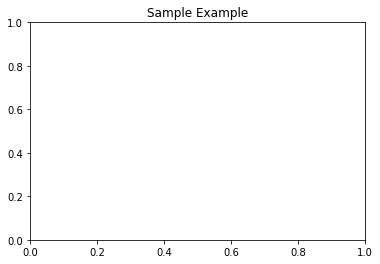

In [33]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example')

In [34]:
def baseline(history):
    return np.mean(history)

In [35]:
show_plot([X_train[0], y_train[0], baseline(X_train[0])], 0, 'Baseline Prediction Example')

TypeError: can only concatenate str (not "float") to str

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [42]:
simple_lstm_model = tf.keras.models.Sequential([
    t,
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()

NameError: name 't' is not defined

In [43]:
for x, y in test_dataset.take(1):
    print(simple_lstm_model.predict(x).shape)

NameError: name 'test_dataset' is not defined

In [44]:
EVALUATION_INTERVAL = 200
EPOCHS = 1000

history = simple_lstm_model.fit(train_dataset, epochs=EPOCHS,
                                  steps_per_epoch=EVALUATION_INTERVAL,
                                  validation_data=test_dataset, validation_steps=50)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'simple_lstm_model' is not defined

In [40]:
for x, y in test_dataset.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

NameError: name 'test_dataset' is not defined

In [41]:
# Importing Libraries

import pandas as pd

# Use to prepare dataset as a time series
def to_time_series_prev(df, columns, n_trail=1, n_lead=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(n_trail, 0, -1):
        dfs.append(df.shift(-i))
        col_names += [(col_name + '(t-{})'.format(i)) for col_name in columns]
        
    # Create leading columns
    for i in range(0, n_lead+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t+{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg



def to_time_series(df, columns, start_from_t0=1, end_from_t0=1):
    '''
    :param df: DataFrame, dataframe object where the columns are the features and labels and the rows are days
    :param columns: list of strings, names of the features and labels (columns of df) to be used in the time series
    :param n_trail: int, number of days behind day 0 that will be used to predict days after day 0
    :param n_lead: int, number of days ahead of day 0 that will be predicted
    
    ---> DataFrame, dataframe object structured like a time series where each row represents an element in the time
                    series, and each column is a feature or label a certain amount of days in the future or past.
    '''
    df = df[columns]
    dfs = []
    col_names = []
    
    # Create trailing columns
    for i in range(start_from_t0, end_from_t0+1):
        dfs.append(df.shift(i))
        col_names += [(col_name + '(t{})'.format(i)) for col_name in columns]
        
    agg = pd.concat(dfs, axis=1)
    agg.columns = col_names
    
    #agg.dropna(inplace=True)
    
    return agg
    

In [4]:


def preprocess_pm(raw_df):
    '''
    Preprocessing raw_df into the shape raw_df should have been after coming out of the fetch process, as well as 
    normalizing the documents.
    '''
    
    # Reshaping DataFrame
    reshaped_df = reshape(raw_df)
    
    # Normalizing and updating documents    
    def update_doclist(s):
        doclist = json.loads(s)
        updated_doclist = []
        for docpath in doclist:
            save_point = os.path.join(os.path.split(docpath)[0], 'normalized')
            norm_docpath = normalize_save_document(docpath, save_point)
            updated_doclist.append(norm_docpath)
            
        return json.dumps(updated_doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])] = reshaped_df['_'.join(['docs', t])].map(update_doclist)
        
    # Preprocessing numerical data
    reshaped_df['log_adj_close'] = np.log(reshaped_df['adjusted_close'])
    reshaped_df['log_adj_daily_returns'] = reshaped_df['log_adj_close'] - reshaped_df['log_adj_close'].shift(-1)
    reshaped_df.dropna(subset=['log_adj_daily_returns'], inplace=True)
    
    # Building vocabulary json file
    path_to_vocab = os.path.join(path_to_data, 'vocab.json')
    
    def vocab_from_doclist(s):
        
        doclist = json.loads(s)
        
        for docpath in doclist:
            with open(docpath, 'r') as f:
                doc = f.read()
            
            build_vocab(doc)
        
        return json.dumps(doclist)
    
    for t in tickers:
        reshaped_df['_'.join(['docs', t])].map(vocab_from_doclist)
        
    # Encoding documents based off of vocabulary json file
    
    
    return reshaped_df

In [5]:
# Writing tfrecords

feature_names = ['log_adj_daily_returns', 'docs_WFC', 'docs_JPM', 'docs_C', 'docs_BAC']
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)


# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    '''Returns a bytes_list from a string / byte.'''
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    '''Returns a float_list from a float / double.'''
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    '''Returns an int64_list from a bool / enum / int / uint.'''
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(sample, feature_names):
    
    feature = {}
    
    for feature_name in feature_names:
        # if feature is a number 
        if isinstance(sample[feature_name], float):
            feature[feature_name] = tf.train.Feature(float_list=tf.train.FloatList(value=[sample[feature_name]]))
        
        # if feature is a doclist
        elif isinstance(sample[feature_name], list):
            lens = list(map(len, sample[feature_name]))
            values = [word for doc in sample[feature_name] for word in doc]
            feature[feature_name + '/vals'] = tf.train.Feature(int64_list=tf.train.Int64List(value=values))
            feature[feature_name + '/lens'] = tf.train.Feature(int64_list=tf.train.Int64List(value=lens))

    return tf.train.Example(features=tf.train.Features(feature=feature))
        


def unpack_doclist(doclist_string):        
    def load_encode_file(filename):
        with open(filename, 'r') as f:
            text = f.read()
        return [vocab[word] for word in text.split()]
    return list(map(load_encode_file, json.loads(doclist_string)))


record_file = 'test.tfrecords'
with tf.io.TFRecordWriter(record_file) as writer:
    for i in range(300, -1, -1):
        row = raw_df_fixed.iloc[i].copy(deep=True)
        # Unpacking Text Features
        row[['_'.join(['docs', t]) for t in tickers]] = row[['_'.join(['docs', t]) for t in tickers]].map(unpack_doclist)
        # Serializing Example to disk
        example = serialize_example(row, feature_names)
        writer.write(example.SerializeToString())
    
